<a href="https://colab.research.google.com/github/4GeeksAcademy/music_genre_identifier/blob/main/Main_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Genre Classification Project
## Index
### EDA

* [1. Importing Libraries](#c1)
* [2. Data Extraction](#c2)
* [3. Exploration and Data Cleaning](#c3)
  * [3.1 General Information](#c3-1)
  * [3.2 Drop Duplicate Information](#c3-2)
  * [3.3 Drop Null Information](#c3-3)
* [4. Univariate Analysis](#c4)
  * [4.1 Dividing our dataset into categorical and numerical](#c4-1)
  * [4.2 Categorical Variable Analysis](#c4-2)
  * [4.3 Numerical Variable Analysis](#c4-3)
* [5. Multivariate Analysis](#c5)
  * [5.1 Encoding Categorical Values and Saving JSON Files](#c5-1)
  * [5.2 Numerical-Categorical Analysis](#c5-2)
* [6. Feature Engineering](#c6)
  * [6.1 New Feature Inference](#c6-1)
  * [6.2 Outliers Analysis](#c6-2)
  * [6.3 Missing Values Analysis](#c6-3)
  * [6.4 Split train/test of both Data Frames](#c6-4)
* [7. Data Processing](#c7)
  * [7.1 Normalization](#c7-1)
  * [7.2 Minmax Scalation](#c7-2)

### Machine Learning

* [8. Machine Learning](#c8)
  * [8.1 Which is the best dataset?](#c8-1)
  * [8.2 Model Optimization](#c8-2)
  * [8.3 Evaluation of the Model](#c8-3)

## EDA

### 1. Importing Libraries <a id='c1'></a>

In [1]:
!git clone https://github.com/4GeeksAcademy/music_genre_identifier.git

Cloning into 'music_genre_identifier'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 123 (delta 2), reused 3 (delta 2), pack-reused 117 (from 2)
Receiving objects: 100% (123/123), 184.76 KiB | 3.49 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
!pip install -r ./music_genre_identifier/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import warnings
import pickle
import kagglehub
from pickle import dump
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import keras_tuner as kt

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

### 2. Data Extraction <a id='c2'></a>

In [4]:
# Download latest versions
path = kagglehub.dataset_download("imsparsh/fma-free-music-archive-small-medium")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fma-free-music-archive-small-medium' dataset.
Path to dataset files: /kaggle/input/fma-free-music-archive-small-medium


In [5]:
# --- PASO 1: Cargar los datos crudos (sin cambios) ---
def load_data(path):
    """
    Carga los archivos tracks.csv y features.csv desde la ruta proporcionada.
    """
    print("Cargando archivos del dataset...")
    try:
        tracks_path = os.path.join(path, 'fma_metadata', 'tracks.csv')
        features_path = os.path.join(path, 'fma_metadata', 'features.csv')
        tracks = pd.read_csv(tracks_path, header=[0, 1], index_col=0)
        features = pd.read_csv(features_path, header=[0, 1, 2], index_col=0)
        print("✅ Archivos cargados correctamente.")
        return tracks, features
    except FileNotFoundError as e:
        print(f"❌ Error: No se encontró el archivo. Revisa la ruta.\n{e}")
        return None, None

# --- PASO 2: Procesar las columnas de características (sin cambios) ---
def process_feature_columns(features_df):
    """
    Combina los 3 niveles de las columnas en un único nombre descriptivo.
    """
    print("\nProcesando nombres de columnas para hacerlos únicos y descriptivos...")
    processed_df = features_df.copy()
    new_columns = ['_'.join(col).strip() for col in processed_df.columns.values]
    processed_df.columns = new_columns
    print("✅ Columnas procesadas.")
    return processed_df

# --- PASO 3: Unir los datos (VERSIÓN CORREGIDA) ---
def create_final_dataframe(processed_features, tracks_df):
    """
    Extrae la variable objetivo (género) y la une con las características.
    """
    print("\nCreando el DataFrame final...")

    # Extraer la variable objetivo 'genre_top'
    target_genre = tracks_df[('track', 'genre_top')]

    # Aplanar el nombre de la Serie de ('track', 'genre_top') a 'genre_top'
    target_genre.name = 'genre_top'

    # Unir las características con el género
    final_df = processed_features.join(target_genre, how="inner")

    print("✅ DataFrame final creado.")
    return final_df

# --- EJECUCIÓN PRINCIPAL (sin cambios) ---

# Usar caché si está disponible, si no, descargar.
path = "/kaggle/input/fma-free-music-archive-small-medium"
if not os.path.exists(path):
    print("Descargando dataset desde Kaggle Hub...")
    path = kagglehub.dataset_download("imsparsh/fma-free-music-archive-small-medium")

print("Ruta del dataset:", path)
print("-" * 30)

# Ejecutar la secuencia de procesamiento
tracks_raw, features_raw = load_data(path)
df = 0

if tracks_raw is not None and features_raw is not None:
    features_processed = process_feature_columns(features_raw)
    df = create_final_dataframe(features_processed, tracks_raw)

    print("\n--- Vista Previa del DataFrame Final ---")
    print(f"Dimensiones del DataFrame: {df.shape}")
    print("\nPrimeras 5 filas del DataFrame final:")
    display(df.head())

Ruta del dataset: /kaggle/input/fma-free-music-archive-small-medium
------------------------------
Cargando archivos del dataset...
✅ Archivos cargados correctamente.

Procesando nombres de columnas para hacerlos únicos y descriptivos...
✅ Columnas procesadas.

Creando el DataFrame final...
✅ DataFrame final creado.

--- Vista Previa del DataFrame Final ---
Dimensiones del DataFrame: (106574, 519)

Primeras 5 filas del DataFrame final:


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        7.180653                 5.230309   
3                        1.888963                 0.760539   
5                        0.527563                -0.077654   
10                       3.702245                -0.291193   
20                      -0.193837                -0.198527   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249321                 1.347620   
3                        0.345297                 2.295201   
5                       -0.279610                 0.685883   
10                       2.196742                -0.234449   
20                       0.201546                 0.258556   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482478                 0.531371   
3                        1.654031                 0.067592   
5                        1.937570                 0.880839   
10                       1.367364                 0.998411   
20                       0.775204                 0.084794   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481593                 2.691455   
3                        1.366848                 1.054094   
5                       -0.923192                -0.927232   
10                       1.770694                 1.604566   
20                      -0.289294                -0.816410   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866868                 1.341231   
3                        0.108103                 0.619185   
5                        0.666617                 1.038546   
10                       0.521217                 1.982386   
20                       0.043851                -0.804761   

          chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  \
track_id                                                     
2                        1.347792                 1.237658   
3                        1.038253                 1.292235   
5                        0.268932                 1.125141   
10                       4.326824                 1.300406   
20                      -0.990958                -0.430381   

          chroma_cens_max_01  chroma_cens_max_02  chroma_cens_max_03  \
track_id                                                               
2                   0.692500            0.569344            0.597041   
3                   0.677641            0.584248            0.581271   
5                   0.611014            0.651471            0.494528   
10                  0.461840            0.540411            0.446708   
20                  0.652864            0.676290            0.670288   

          chroma_cens_max_04  chroma_cens_max_05  chroma_cens_max_06  \
track_id                                                               
2                   0.625864            0.567330            0.443949   
3                   0.581182            0.454241            0.464841   
5                   0.448799            0.468624            0.454021   
10                  0.647553            0.591908            0.513306   
20                  0.598666            0.653607            0.697645   

          chroma_cens_max_07  chroma_cens_max_08  chroma_cens_max_09  \
track_id                                                               
2                   0.487976            0.497327            0.574435   
3                   0.542833            0.664720            0.511329   
5                   0.497172            0.559755            0.671287   
10                  0.651501  

In [6]:
print(os.listdir(path))

['fma_medium', 'fma_metadata', 'fma_small']


### 3. Exploration and Data Cleaning <a id='c3'></a>

#### 3.1 General Information <a id='c3-1'></a>

In [7]:
print("\nPrimeras 5 filas del DataFrame final (df):")
display(df.head())


Primeras 5 filas del DataFrame final (df):


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        7.180653                 5.230309   
3                        1.888963                 0.760539   
5                        0.527563                -0.077654   
10                       3.702245                -0.291193   
20                      -0.193837                -0.198527   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249321                 1.347620   
3                        0.345297                 2.295201   
5                       -0.279610                 0.685883   
10                       2.196742                -0.234449   
20                       0.201546                 0.258556   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482478                 0.531371   
3                        1.654031                 0.067592   
5                        1.937570                 0.880839   
10                       1.367364                 0.998411   
20                       0.775204                 0.084794   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481593                 2.691455   
3                        1.366848                 1.054094   
5                       -0.923192                -0.927232   
10                       1.770694                 1.604566   
20                      -0.289294                -0.816410   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866868                 1.341231   
3                        0.108103                 0.619185   
5                        0.666617                 1.038546   
10                       0.521217                 1.982386   
20                       0.043851                -0.804761   

          chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  \
track_id                                                     
2                        1.347792                 1.237658   
3                        1.038253                 1.292235   
5                        0.268932                 1.125141   
10                       4.326824                 1.300406   
20                      -0.990958                -0.430381   

          chroma_cens_max_01  chroma_cens_max_02  chroma_cens_max_03  \
track_id                                                               
2                   0.692500            0.569344            0.597041   
3                   0.677641            0.584248            0.581271   
5                   0.611014            0.651471            0.494528   
10                  0.461840            0.540411            0.446708   
20                  0.652864            0.676290            0.670288   

          chroma_cens_max_04  chroma_cens_max_05  chroma_cens_max_06  \
track_id                                                               
2                   0.625864            0.567330            0.443949   
3                   0.581182            0.454241            0.464841   
5                   0.448799            0.468624            0.454021   
10                  0.647553            0.591908            0.513306   
20                  0.598666            0.653607            0.697645   

          chroma_cens_max_07  chroma_cens_max_08  chroma_cens_max_09  \
track_id                                                               
2                   0.487976            0.497327            0.574435   
3                   0.542833            0.664720            0.511329   
5                   0.497172            0.559755            0.671287   
10                  0.651501  

In [8]:
print("\nInformación general del DataFrame final (df):")
df.info()


Información general del DataFrame final (df):
<class 'pandas.core.frame.DataFrame'>
Index: 106574 entries, 2 to 155320
Columns: 519 entries, chroma_cens_kurtosis_01 to genre_top
dtypes: float64(518), object(1)
memory usage: 422.8+ MB


In [9]:
print("\nEstadísticas descriptivas del DataFrame final (df):")
display(df.describe())


Estadísticas descriptivas del DataFrame final (df):


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
count            106574.000000            106574.000000   
mean                  0.439999                 0.199756   
std                  32.285524                11.120903   
min                  -1.955806                -1.936607   
25%                  -0.636597                -0.665684   
50%                  -0.176557                -0.221131   
75%                   0.485000                 0.410097   
max                8843.367188              2864.075195   

       chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
count            106574.000000            106574.000000   
mean                  0.334683                 0.270263   
std                   9.980692                19.074557   
min                  -1.967450                -3.000000   
25%                  -0.629114                -0.644747   
50%                  -0.152708                -0.191032   
75%                   0.529836                 0.446800   
max                1777.615967              4257.045898   

       chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
count            106574.000000            106574.000000   
mean                  0.294806                 0.315635   
std                  15.025603                12.176182   
min                  -1.921206                -1.923740   
25%                  -0.656779                -0.622579   
50%                  -0.198025                -0.152089   
75%                   0.452680                 0.513112   
max                3188.034424              2809.779297   

       chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
count            106574.000000            106574.000000   
mean                  0.273511                 0.334927   
std                  16.975991                15.486402   
min                  -1.935382                -3.000000   
25%                  -0.646798                -0.635741   
50%                  -0.187959                -0.161478   
75%                   0.472161                 0.525814   
max                4281.090820              3869.482178   

       chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
count            106574.000000            106574.000000   
mean                  0.201939                 0.285631   
std                   7.364308                 8.175257   
min                  -3.000000                -3.000000   
25%                  -0.667799                -0.660292   
50%                  -0.214547                -0.181836   
75%                   0.432480                 0.495568   
max                1217.209473              1772.918213   

       chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  chroma_cens_max_01  \
count            106574.000000            106574.000000       106574.000000   
mean                  0.430549                 0.474014            0.622666   
std                  19.343114                22.967662            0.086195   
min                  -3.000000                -3.000000            0.021007   
25%                  -0.636309                -0.641450            0.571389   
50%                  -0.160667                -0.169876            0.642000   
75%                   0.534744                 0.525550            0.684615   
max                3887.379639              4995.784668            1.000000   

       chroma_cens_max_02  chroma_cens_max_03  chroma_cens_max_04  \
count       106574.000000       106574.000000       106574.000000   
mean             0.593421            0.610000            0.588934   
std              0.083298            0.088985            0.087267   
min              0.051882            0.054485            0.000000   
25%              0.527862            0.546873            0.517306   
50%              0.611781            0.636938            0.607987   
75%              0.661018            0.680843            0.660160   
max              0.769800            0.759050            0.769800   

       chroma

In [10]:
print("\nTipos de datos de cada columna del DataFrame final (df):")
print(df.dtypes)


Tipos de datos de cada columna del DataFrame final (df):
chroma_cens_kurtosis_01    float64
chroma_cens_kurtosis_02    float64
chroma_cens_kurtosis_03    float64
chroma_cens_kurtosis_04    float64
chroma_cens_kurtosis_05    float64
                            ...   
zcr_median_01              float64
zcr_min_01                 float64
zcr_skew_01                float64
zcr_std_01                 float64
genre_top                   object
Length: 519, dtype: object


#### 3.2 Duplicated Data <a id='c3-2'></a>

In [11]:
rows = df.shape[0]
duplicated_rows = df.duplicated().sum()
print(f'Tenemos {duplicated_rows} filas duplicadas de {rows}')

Tenemos 1675 filas duplicadas de 106574


In [12]:
rows = df.shape[0]
df = df.drop_duplicates()
print(f'Ahora tenemos {df.shape[0]} filas')

Ahora tenemos 104899 filas


#### 3.3 Null Data <a id='c3-3'></a>

There is no null data

In [13]:
df.isna().sum()

chroma_cens_kurtosis_01        0
chroma_cens_kurtosis_02        0
chroma_cens_kurtosis_03        0
chroma_cens_kurtosis_04        0
chroma_cens_kurtosis_05        0
                           ...  
zcr_median_01                  0
zcr_min_01                     0
zcr_skew_01                    0
zcr_std_01                     0
genre_top                  55766
Length: 519, dtype: int64

In [14]:
missing_genre_top = df['genre_top'].isna()
num_missing_genre_top = missing_genre_top.sum()
percentage_missing_genre_top = (num_missing_genre_top / df.shape[0]) * 100

print(f"Número de valores faltantes en 'genre_top': {num_missing_genre_top}")
print(f"Porcentaje de valores faltantes en 'genre_top': {percentage_missing_genre_top:.2f}%")

Número de valores faltantes en 'genre_top': 55766
Porcentaje de valores faltantes en 'genre_top': 53.16%


#### 3.4 Drop Irrelevant Data <a id='c3-4'></a>

Ya vienen todos los datos necesarios.

Encontrar valores faltantes para genre_top, unir dataframe con informacion del genero detallada

In [15]:
print(os.listdir(os.path.join(path, 'fma_metadata')))

['echonest.csv', 'raw_genres.csv', 'raw_artists.csv', 'features.csv', 'genres.csv', 'README.txt', 'not_found.pickle', 'tracks.csv', 'raw_tracks.csv', 'raw_albums.csv', 'raw_echonest.csv', 'checksums']


In [16]:
genres_path = os.path.join(path, 'fma_metadata', 'genres.csv')
genres_df = pd.read_csv(genres_path, index_col=0)
display(genres_df.head())

#tracks  parent          title  top_level
genre_id                                           
1            8693      38    Avant-Garde         38
2            5271       0  International          2
3            1752       0          Blues          3
4            4126       0           Jazz          4
5            4106       0      Classical          5

In [17]:
# Seleccionar las columnas de géneros detallados del DataFrame tracks
tracks_genres = tracks_raw[[("track", "genres"), ("track", "genres_all")]]

# eliminamos la etiqueta del primer nivel del índice para simplificar la estructura de datos cuando un índice tiene jerarquías.
tracks_genres.columns = tracks_genres.columns.droplevel(0)

# Unir df con tracks_genres usando el índice track_id (asegurando que df_merged incluya genre_top de df)
df_merged = df.merge(tracks_genres, left_index=True, right_index=True, how="left")


# Mostrar las primeras filas del DataFrame combinado con las columnas de género detalladas
display(df_merged.head())

chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        7.180653                 5.230309   
3                        1.888963                 0.760539   
5                        0.527563                -0.077654   
10                       3.702245                -0.291193   
20                      -0.193837                -0.198527   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249321                 1.347620   
3                        0.345297                 2.295201   
5                       -0.279610                 0.685883   
10                       2.196742                -0.234449   
20                       0.201546                 0.258556   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482478                 0.531371   
3                        1.654031                 0.067592   
5                        1.937570                 0.880839   
10                       1.367364                 0.998411   
20                       0.775204                 0.084794   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481593                 2.691455   
3                        1.366848                 1.054094   
5                       -0.923192                -0.927232   
10                       1.770694                 1.604566   
20                      -0.289294                -0.816410   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866868                 1.341231   
3                        0.108103                 0.619185   
5                        0.666617                 1.038546   
10                       0.521217                 1.982386   
20                       0.043851                -0.804761   

          chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  \
track_id                                                     
2                        1.347792                 1.237658   
3                        1.038253                 1.292235   
5                        0.268932                 1.125141   
10                       4.326824                 1.300406   
20                      -0.990958                -0.430381   

          chroma_cens_max_01  chroma_cens_max_02  chroma_cens_max_03  \
track_id                                                               
2                   0.692500            0.569344            0.597041   
3                   0.677641            0.584248            0.581271   
5                   0.611014            0.651471            0.494528   
10                  0.461840            0.540411            0.446708   
20                  0.652864            0.676290            0.670288   

          chroma_cens_max_04  chroma_cens_max_05  chroma_cens_max_06  \
track_id                                                               
2                   0.625864            0.567330            0.443949   
3                   0.581182            0.454241            0.464841   
5                   0.448799            0.468624            0.454021   
10                  0.647553            0.591908            0.513306   
20                  0.598666            0.653607            0.697645   

          chroma_cens_max_07  chroma_cens_max_08  chroma_cens_max_09  \
track_id                                                               
2                   0.487976            0.497327            0.574435   
3                   0.542833            0.664720            0.511329   
5                   0.497172            0.559755            0.671287   
10                  0.651501  

Convertir strings de listas a listas reales

In [18]:
import ast

def parse_genre_list(genre_string):
    try:
        # Usamos ast.literal_eval para evaluar la cadena como una expresión Python (una lista en este caso)
        return ast.literal_eval(genre_string)
    except (ValueError, SyntaxError):
        # Si hay un error al evaluar, por ejemplo, la cadena no es una lista válida, devolvemos una lista vacía
        return []

# Aplicar la función a las columnas genres y genres_all para convertir los strings a listas
df_merged["genres"] = df_merged["genres"].apply(parse_genre_list)
df_merged["genres_all"] = df_merged["genres_all"].apply(parse_genre_list)

print("Columnas 'genres' y 'genres_all' convertidas a tipo lista.")
print("\nPrimeras filas con tipos de datos actualizados:")
display(df_merged[['genres', 'genres_all', 'genre_top']].head())

Columnas 'genres' y 'genres_all' convertidas a tipo lista.

Primeras filas con tipos de datos actualizados:


genres         genres_all genre_top
track_id                                        
2              [21]               [21]   Hip-Hop
3              [21]               [21]   Hip-Hop
5              [21]               [21]   Hip-Hop
10             [10]               [10]       Pop
20        [76, 103]  [17, 10, 76, 103]       NaN

Verificar valores faltantes.

In [19]:
missing_genre_top_after_fill = df_merged["genre_top"].isna().sum()
percentage_missing_genre_top_after_fill = (missing_genre_top_after_fill / df_merged.shape[0]) * 100

print(f"Número de valores faltantes restantes en genre_top después de rellenar: {missing_genre_top_after_fill}")
print(f"Porcentaje de valores faltantes restantes en genre_top después de rellenar: {percentage_missing_genre_top_after_fill:.2f}%")

Número de valores faltantes restantes en genre_top después de rellenar: 55766
Porcentaje de valores faltantes restantes en genre_top después de rellenar: 53.16%


In [20]:
display(df_merged.head())

chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        7.180653                 5.230309   
3                        1.888963                 0.760539   
5                        0.527563                -0.077654   
10                       3.702245                -0.291193   
20                      -0.193837                -0.198527   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249321                 1.347620   
3                        0.345297                 2.295201   
5                       -0.279610                 0.685883   
10                       2.196742                -0.234449   
20                       0.201546                 0.258556   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482478                 0.531371   
3                        1.654031                 0.067592   
5                        1.937570                 0.880839   
10                       1.367364                 0.998411   
20                       0.775204                 0.084794   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481593                 2.691455   
3                        1.366848                 1.054094   
5                       -0.923192                -0.927232   
10                       1.770694                 1.604566   
20                      -0.289294                -0.816410   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866868                 1.341231   
3                        0.108103                 0.619185   
5                        0.666617                 1.038546   
10                       0.521217                 1.982386   
20                       0.043851                -0.804761   

          chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  \
track_id                                                     
2                        1.347792                 1.237658   
3                        1.038253                 1.292235   
5                        0.268932                 1.125141   
10                       4.326824                 1.300406   
20                      -0.990958                -0.430381   

          chroma_cens_max_01  chroma_cens_max_02  chroma_cens_max_03  \
track_id                                                               
2                   0.692500            0.569344            0.597041   
3                   0.677641            0.584248            0.581271   
5                   0.611014            0.651471            0.494528   
10                  0.461840            0.540411            0.446708   
20                  0.652864            0.676290            0.670288   

          chroma_cens_max_04  chroma_cens_max_05  chroma_cens_max_06  \
track_id                                                               
2                   0.625864            0.567330            0.443949   
3                   0.581182            0.454241            0.464841   
5                   0.448799            0.468624            0.454021   
10                  0.647553            0.591908            0.513306   
20                  0.598666            0.653607            0.697645   

          chroma_cens_max_07  chroma_cens_max_08  chroma_cens_max_09  \
track_id                                                               
2                   0.487976            0.497327            0.574435   
3                   0.542833            0.664720            0.511329   
5                   0.497172            0.559755            0.671287   
10                  0.651501  

filas que aun tienen faltantes

In [21]:
missing_genre_top_mask = df_merged["genre_top"].isna()
empty_genres_mask = df_merged["genres"].apply(lambda x: len(x) == 0)
empty_genres_all_mask = df_merged["genres_all"].apply(lambda x: len(x) == 0)

filas_faltantes_mask = missing_genre_top_mask & empty_genres_mask & empty_genres_all_mask

track_ids_missing_and_empty = df_merged.loc[filas_faltantes_mask].index

print(f"Numero de IDs de pista con genre_top faltante y listas de genero vacias: {len(track_ids_missing_and_empty)}")
print("IDs de pistas con genre_top faltante y listas de género vacias:")
print(track_ids_missing_and_empty.tolist())

print(df_merged.shape[0])

Numero de IDs de pista con genre_top faltante y listas de genero vacias: 2140
IDs de pistas con genre_top faltante y listas de género vacias:
[613, 1213, 1216, 1217, 3276, 3678, 4505, 4532, 4533, 4534, 5081, 5097, 5921, 5922, 5923, 5925, 6327, 6668, 6794, 7179, 7180, 7181, 7182, 7547, 7737, 8596, 9156, 9161, 9181, 9182, 9185, 9209, 9223, 9330, 9331, 9332, 9334, 9335, 9343, 9362, 9379, 9381, 9395, 9396, 9399, 9401, 9414, 9420, 9647, 9648, 9649, 9660, 9661, 9889, 9892, 9900, 9901, 9903, 9979, 9981, 9983, 9984, 10183, 10185, 10212, 10345, 10355, 10370, 10417, 10419, 10431, 10461, 10792, 10831, 10832, 10939, 11202, 11203, 11463, 11618, 11619, 11621, 11622, 11624, 11625, 11655, 11657, 11660, 11667, 11668, 11718, 11731, 11996, 12178, 12181, 12197, 12198, 12201, 12370, 12391, 13151, 13967, 13968, 13998, 14000, 14004, 14005, 14006, 14007, 14011, 14012, 14111, 14112, 14185, 14274, 14291, 14393, 14395, 14396, 14567, 14628, 14629, 14683, 14687, 14882, 14886, 14887, 14893, 14895, 14896, 14897, 149

El resto de filas sin datos de genre_top las eliminamos

In [22]:
df_merged = df_merged.dropna(subset=['genre_top'])

print(f"Número de filas después de eliminar faltantes en 'genre_top': {df_merged.shape[0]}")
print(f"Número de valores faltantes en 'genre_top' después de eliminar: {df_merged['genre_top'].isna().sum()}")

display(df_merged.head())

Número de filas después de eliminar faltantes en 'genre_top': 49133
Número de valores faltantes en 'genre_top' después de eliminar: 0


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        7.180653                 5.230309   
3                        1.888963                 0.760539   
5                        0.527563                -0.077654   
10                       3.702245                -0.291193   
134                      0.918445                 0.674147   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249321                 1.347620   
3                        0.345297                 2.295201   
5                       -0.279610                 0.685883   
10                       2.196742                -0.234449   
134                      0.577818                 1.281117   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482478                 0.531371   
3                        1.654031                 0.067592   
5                        1.937570                 0.880839   
10                       1.367364                 0.998411   
134                      0.933746                 0.078177   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481593                 2.691455   
3                        1.366848                 1.054094   
5                       -0.923192                -0.927232   
10                       1.770694                 1.604566   
134                      1.199204                -0.175223   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866868                 1.341231   
3                        0.108103                 0.619185   
5                        0.666617                 1.038546   
10                       0.521217                 1.982386   
134                      0.925482                 1.438509   

          chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  \
track_id                                                     
2                        1.347792                 1.237658   
3                        1.038253                 1.292235   
5                        0.268932                 1.125141   
10                       4.326824                 1.300406   
134                      0.123328                 0.797199   

          chroma_cens_max_01  chroma_cens_max_02  chroma_cens_max_03  \
track_id                                                               
2                   0.692500            0.569344            0.597041   
3                   0.677641            0.584248            0.581271   
5                   0.611014            0.651471            0.494528   
10                  0.461840            0.540411            0.446708   
134                 0.670821            0.596978            0.614920   

          chroma_cens_max_04  chroma_cens_max_05  chroma_cens_max_06  \
track_id                                                               
2                   0.625864            0.567330            0.443949   
3                   0.581182            0.454241            0.464841   
5                   0.448799            0.468624            0.454021   
10                  0.647553            0.591908            0.513306   
134                 0.535825            0.617804            0.623351   

          chroma_cens_max_07  chroma_cens_max_08  chroma_cens_max_09  \
track_id                                                               
2                   0.487976            0.497327            0.574435   
3                   0.542833            0.664720            0.511329   
5                   0.497172            0.559755            0.671287   
10                  0.651501  

In [23]:
numerical_variables = df_merged.select_dtypes(include=['number']).columns.tolist()
print("Numerical Variables:", numerical_variables)

categorical_variables = df_merged.select_dtypes(exclude=['number']).columns.tolist()
print("Categorical Variables:", categorical_variables)

print(df_merged.dtypes)

Numerical Variables: ['chroma_cens_kurtosis_01', 'chroma_cens_kurtosis_02', 'chroma_cens_kurtosis_03', 'chroma_cens_kurtosis_04', 'chroma_cens_kurtosis_05', 'chroma_cens_kurtosis_06', 'chroma_cens_kurtosis_07', 'chroma_cens_kurtosis_08', 'chroma_cens_kurtosis_09', 'chroma_cens_kurtosis_10', 'chroma_cens_kurtosis_11', 'chroma_cens_kurtosis_12', 'chroma_cens_max_01', 'chroma_cens_max_02', 'chroma_cens_max_03', 'chroma_cens_max_04', 'chroma_cens_max_05', 'chroma_cens_max_06', 'chroma_cens_max_07', 'chroma_cens_max_08', 'chroma_cens_max_09', 'chroma_cens_max_10', 'chroma_cens_max_11', 'chroma_cens_max_12', 'chroma_cens_mean_01', 'chroma_cens_mean_02', 'chroma_cens_mean_03', 'chroma_cens_mean_04', 'chroma_cens_mean_05', 'chroma_cens_mean_06', 'chroma_cens_mean_07', 'chroma_cens_mean_08', 'chroma_cens_mean_09', 'chroma_cens_mean_10', 'chroma_cens_mean_11', 'chroma_cens_mean_12', 'chroma_cens_median_01', 'chroma_cens_median_02', 'chroma_cens_median_03', 'chroma_cens_median_04', 'chroma_cens_m

Convertimos las variables a tipos más ajustados para ahorrar en memoria

In [24]:
for col in numerical_variables:
    df_merged[col] = df_merged[col].astype('float16')

print(df_merged.dtypes)

chroma_cens_kurtosis_01    float16
chroma_cens_kurtosis_02    float16
chroma_cens_kurtosis_03    float16
chroma_cens_kurtosis_04    float16
chroma_cens_kurtosis_05    float16
                            ...   
zcr_skew_01                float16
zcr_std_01                 float16
genre_top                   object
genres                      object
genres_all                  object
Length: 521, dtype: object


### Análisis Univariante

#### Categorical Variable Analysis

In [25]:
len(set(df_merged['genre_top']))

16

Para genres_top

Cómo no podemos observar bien todos los géneros, vamos a dividir la gráfica en dos:

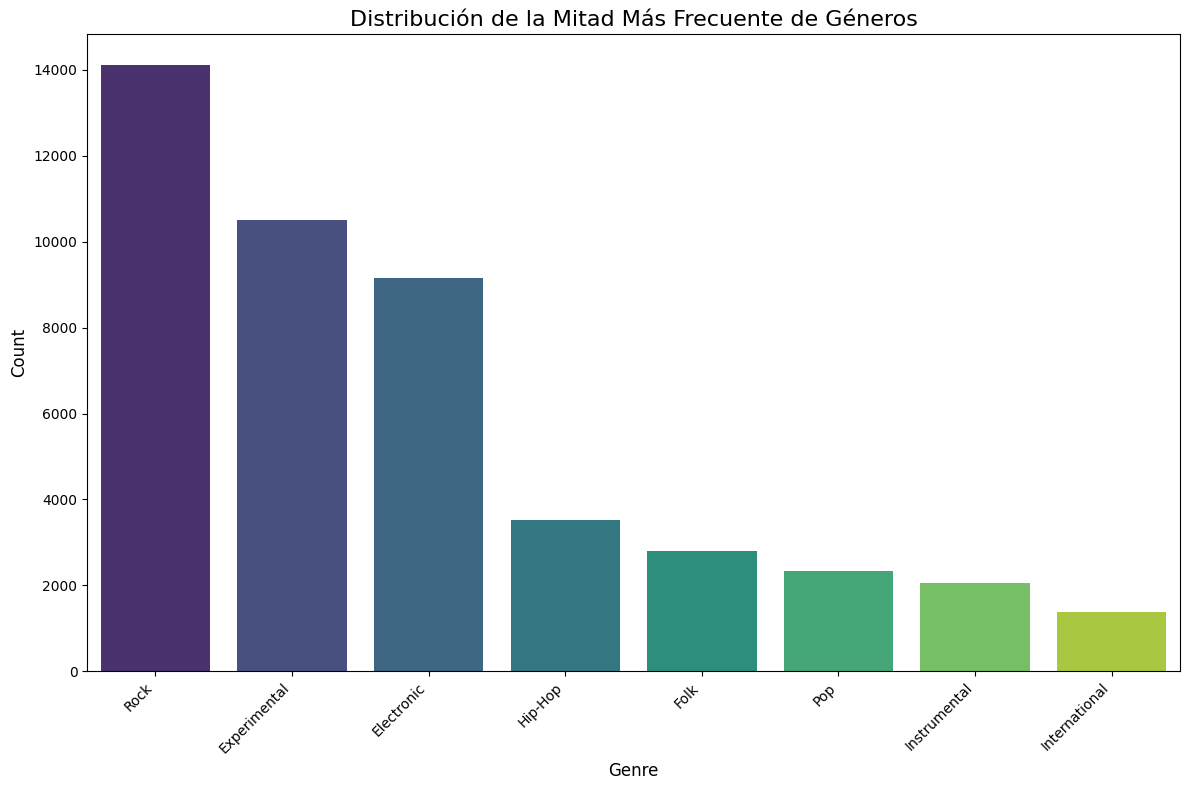

In [26]:
genre_counts = df_merged['genre_top'].value_counts()


top_half_genres = genre_counts.index[:len(genre_counts) // 2]

# 3. Crear el gráfico usando el parámetro 'order' para mostrar solo la selección
plt.figure(figsize=(12, 8)) # Ajustamos el tamaño para menos barras
sns.countplot(data=df_merged, x="genre_top", palette='viridis', order=top_half_genres)

plt.title("Distribución de la Mitad Más Frecuente de Géneros", fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=45, ha='right') # ha='right' alinea mejor las etiquetas

plt.tight_layout()
plt.show()

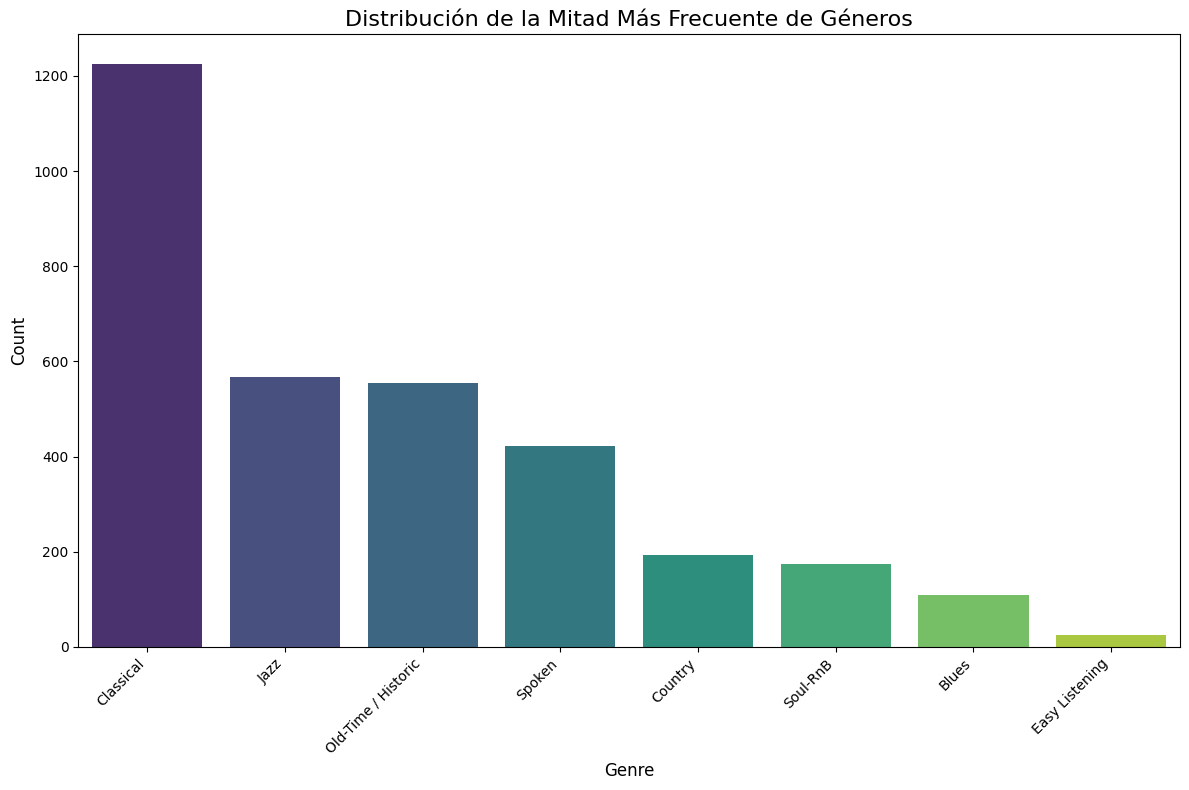

In [27]:
genre_counts = df_merged['genre_top'].value_counts()


top_half_genres = genre_counts.index[len(genre_counts) // 2:]

# 3. Crear el gráfico usando el parámetro 'order' para mostrar solo la selección
plt.figure(figsize=(12, 8)) # Ajustamos el tamaño para menos barras
sns.countplot(data=df_merged, x="genre_top", palette='viridis', order=top_half_genres)

plt.title("Distribución de la Mitad Más Frecuente de Géneros", fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=45, ha='right') # ha='right' alinea mejor las etiquetas

plt.tight_layout()
plt.show()

Cómo podemos observar, predominan sobre todo los géneros "Electronic", "Rock", "Experimental", "Pop" y "Folk".

### Numerical Variable Analysis

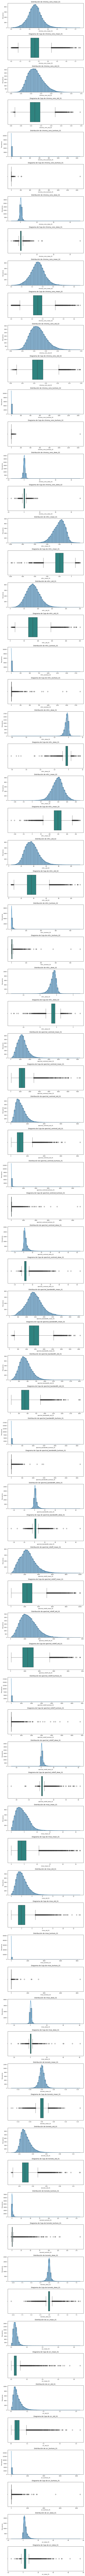

In [28]:
selected_numerical_cols = [
    'chroma_cens_mean_01', 'chroma_cens_std_01', 'chroma_cens_kurtosis_01', 'chroma_cens_skew_01',
    'chroma_cens_mean_02', 'chroma_cens_std_02', 'chroma_cens_kurtosis_02', 'chroma_cens_skew_02',
    'mfcc_mean_01', 'mfcc_std_01', 'mfcc_kurtosis_01', 'mfcc_skew_01',
    'mfcc_mean_02', 'mfcc_std_02', 'mfcc_kurtosis_02', 'mfcc_skew_02',
    'spectral_centroid_mean_01', 'spectral_centroid_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_skew_01',
    'spectral_bandwidth_mean_01', 'spectral_bandwidth_std_01', 'spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_skew_01',
    'spectral_rolloff_mean_01', 'spectral_rolloff_std_01', 'spectral_rolloff_kurtosis_01', 'spectral_rolloff_skew_01',
    'rmse_mean_01', 'rmse_std_01', 'rmse_kurtosis_01', 'rmse_skew_01',
    'tonnetz_mean_01', 'tonnetz_std_01', 'tonnetz_kurtosis_01', 'tonnetz_skew_01',
    'zcr_mean_01', 'zcr_std_01', 'zcr_kurtosis_01', 'zcr_skew_01',
]

# Filtrar solo las columnas que existen en el DataFrame
cols_to_plot = [col for col in selected_numerical_cols if col in df_merged.columns]

# Generar histogramas y diagramas de caja para las columnas seleccionadas
n_vars = len(cols_to_plot)
n_rows = n_vars * 2  # Dos filas por variable: histograma y diagrama de caja
n_cols = 1

plt.figure(figsize=(8, n_rows * 3))

for i, col in enumerate(cols_to_plot):
    # Subplot para el histograma (fila 2*i + 1)
    plt.subplot(n_rows, n_cols, i * 2 + 1)
    sns.histplot(data=df_merged, x=col, kde=True, bins=50)
    plt.title(f"Distribución de {col}", fontsize=10)
    plt.xlabel(col, fontsize=8)
    plt.ylabel("Frecuencia", fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

    # Subplot para el diagrama de caja (fila 2*i + 2)
    plt.subplot(n_rows, n_cols, i * 2 + 2)
    sns.boxplot(data=df_merged, x=col, palette="viridis")
    plt.title(f"Diagrama de Caja de {col}", fontsize=10)
    plt.xlabel(col, fontsize=8)
    plt.xticks(fontsize=7)

plt.tight_layout()
plt.show()

### Análisis Multivariante

#### Análisis Numérico-Categórico

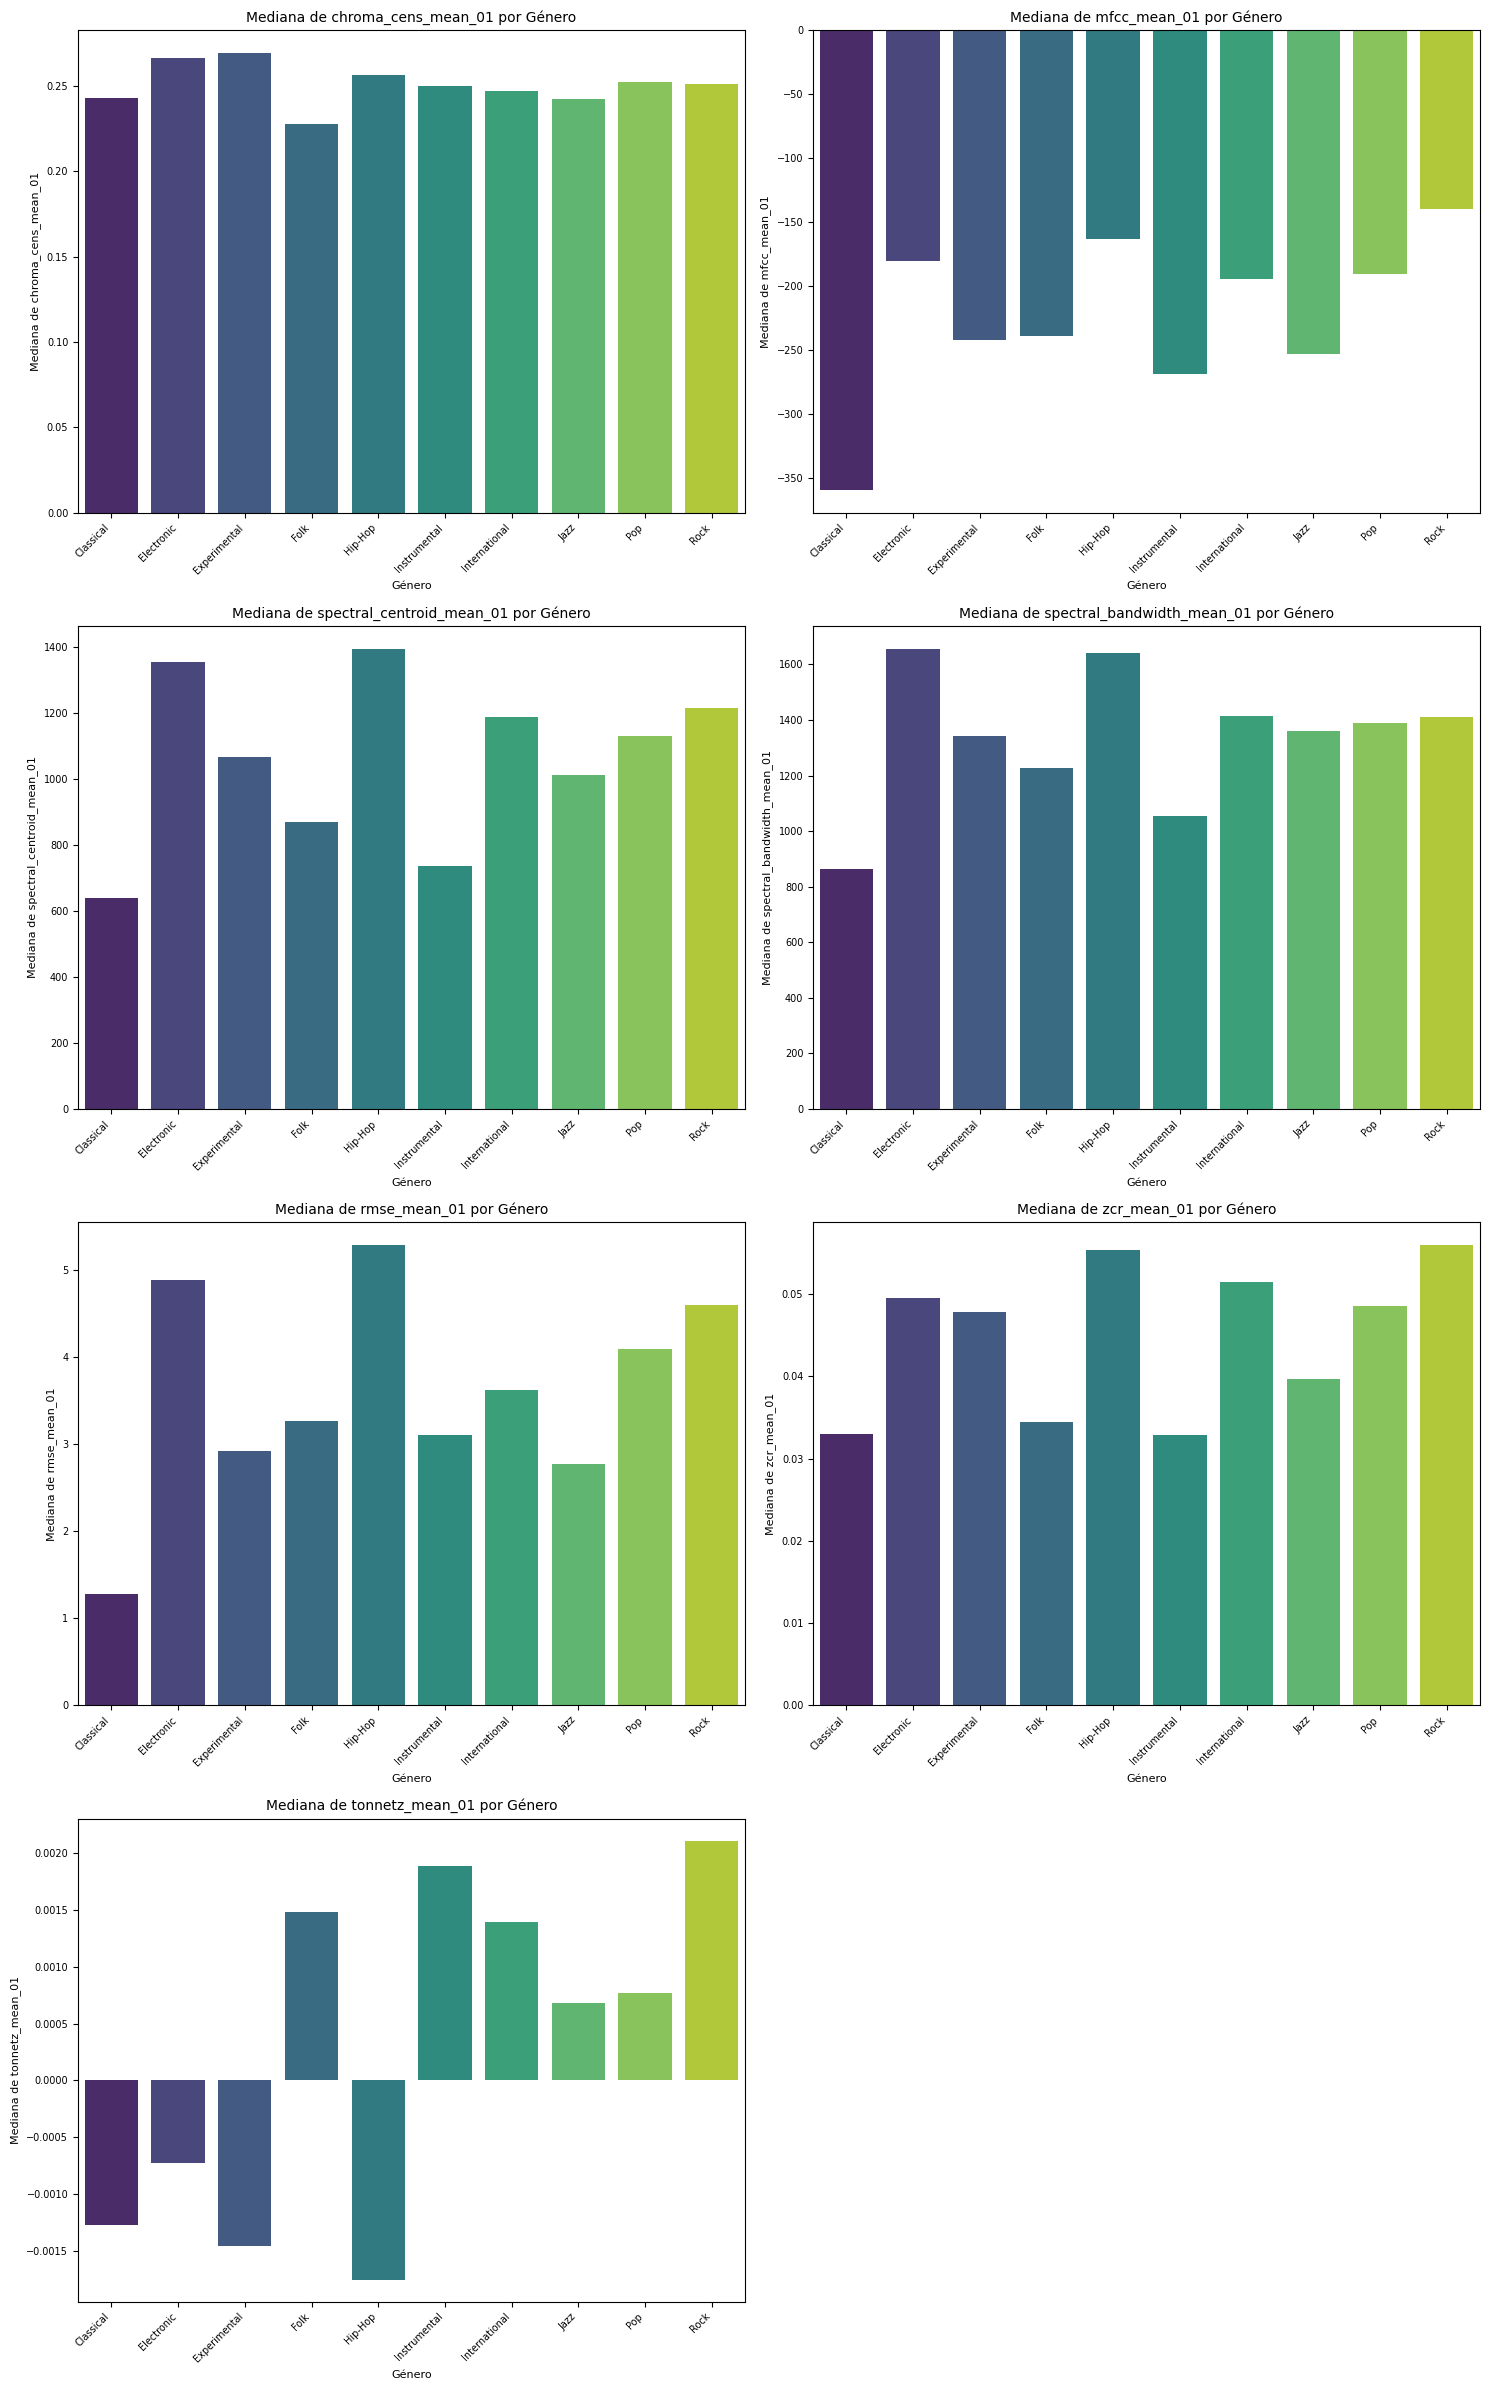

In [29]:
selected_numerical_cols_multivariate = [
    'chroma_cens_mean_01',
    'mfcc_mean_01',
    'spectral_centroid_mean_01',
    'spectral_bandwidth_mean_01',
    'rmse_mean_01',
    'zcr_mean_01',
    'tonnetz_mean_01'
]
cols_to_plot_multivariate = [col for col in selected_numerical_cols_multivariate if col in df_merged.columns]

top_genres = df_merged["genre_top"].value_counts().nlargest(10).index.tolist()

df_top_genres = df_merged[df_merged["genre_top"].isin(top_genres)].copy()
median_by_genre = df_top_genres.groupby("genre_top")[cols_to_plot_multivariate].median().reset_index()

# Generamos barplots para las medianas de las columnas numericas seleccionadas vs genre_top
n_cols = 2
n_rows = (len(cols_to_plot_multivariate) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 6))

for i, col in enumerate(cols_to_plot_multivariate):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.barplot(data=median_by_genre, x="genre_top", y=col, palette="viridis")
    plt.title(f"Mediana de {col} por Género", fontsize=10)
    plt.xlabel("Género", fontsize=8)
    plt.ylabel(f"Mediana de {col}", fontsize=8)
    plt.xticks(rotation=45, ha="right", fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.show()

#### Análisis Númerico-Numérico

Al tener tantas variables, hemos recurrido a ayuda externa para poder elegir las más representativas a la hora de graficarlas con sentido. Hemos elegido estas 8 variables:

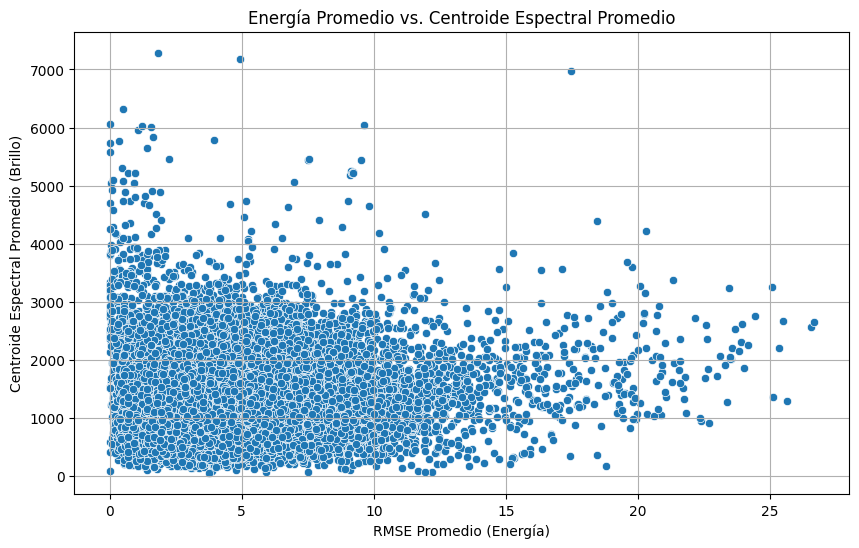

In [30]:
# 1. Energía vs. Brillo
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='rmse_mean_01', y='spectral_centroid_mean_01')
plt.title('Energía Promedio vs. Centroide Espectral Promedio')
plt.xlabel('RMSE Promedio (Energía)')
plt.ylabel('Centroide Espectral Promedio (Brillo)')
plt.grid(True)
plt.show()

Esta combinación muestra si las canciones con más energía general (rmse) también tienden a tener un espectro más brillante o agudo (spectral_centroid). Una relación positiva indica que los temas más intensos suelen ser también más "claros" o "metálicos".

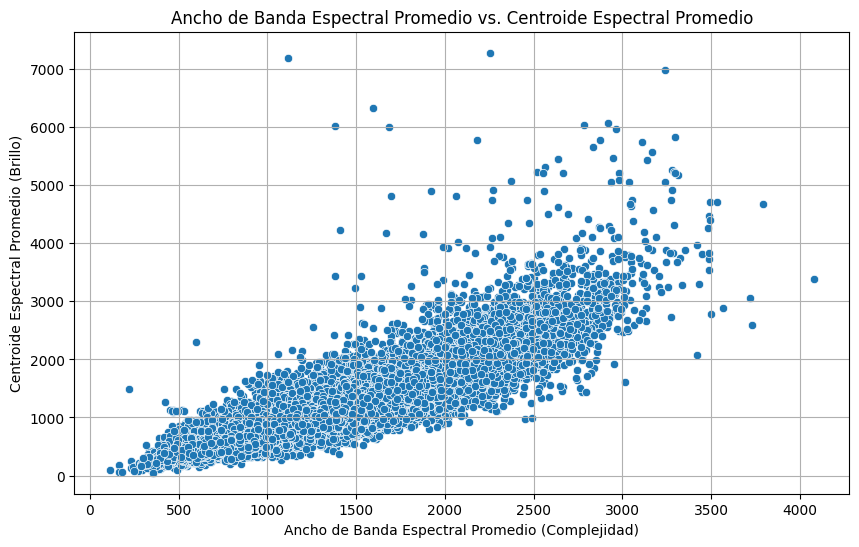

In [31]:
# 2. Complejidad vs. Brillo
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='spectral_bandwidth_mean_01', y='spectral_centroid_mean_01')
plt.title('Ancho de Banda Espectral Promedio vs. Centroide Espectral Promedio')
plt.xlabel('Ancho de Banda Espectral Promedio (Complejidad)')
plt.ylabel('Centroide Espectral Promedio (Brillo)')
plt.grid(True)
plt.show()

Este gráfico de dispersión revela si las canciones con un espectro más amplio (más "complejo" o "ruidoso") también tienen un centro de masa espectral más alto. Una correlación positiva podría indica que la música con más riqueza de frecuencias también es más brillante.

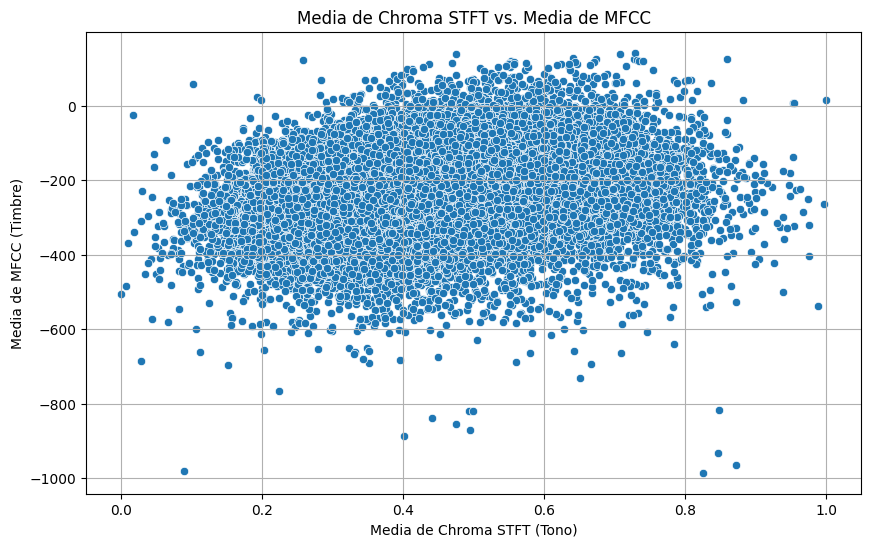

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='chroma_stft_mean_01', y='mfcc_mean_01')
plt.title('Media de Chroma STFT vs. Media de MFCC')
plt.xlabel('Media de Chroma STFT (Tono)')
plt.ylabel('Media de MFCC (Timbre)')
plt.grid(True)
plt.show()

Esta es una combinación un poco más abstracta, pero interesante. El chroma mide la distribución del tono, mientras que el mfcc se centra en la forma del espectro, relacionada con el timbre. Al graficarlos, podemos ver si ciertos patrones tonales (chroma) se asocian con timbres específicos (mfcc), aunque la relación no sea tan directa como en los casos anteriores.

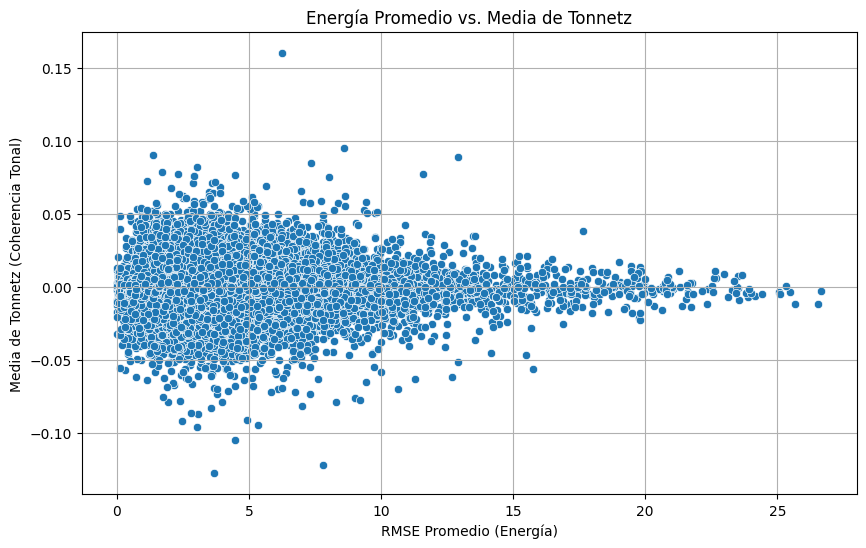

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='rmse_mean_01', y='tonnetz_mean_01')
plt.title('Energía Promedio vs. Media de Tonnetz')
plt.xlabel('RMSE Promedio (Energía)')
plt.ylabel('Media de Tonnetz (Coherencia Tonal)')
plt.grid(True)
plt.show()


Con este gráfico podemos explorar si las canciones con mayor energía total (rmse) tienen una estructura armónica más definida y coherente (tonnetz). Un patrón interesante podría ser que las canciones más "fuertes" o "ruidosas" tienden a tener una estructura tonal menos clara.

### Análisis Categórico-Categórico

Éste análisis no se puede realizar debido a que tenemos unicamente una variable categórica, "genre_top"

### Análisis de correlaciones

In [34]:

cols_18 = [
'mfcc_mean_01','mfcc_mean_02','mfcc_mean_03','mfcc_mean_04',
'mfcc_std_01','mfcc_std_02',
'spectral_centroid_mean_01',
'spectral_bandwidth_mean_01',
'spectral_rolloff_mean_01','zcr_mean_01','zcr_std_01','rmse_mean_01',
'chroma_stft_mean_01','chroma_stft_std_01','tonnetz_mean_01',
'mfcc_kurtosis_01','mfcc_skew_01','spectral_centroid_kurtosis_01'
]
X = df_merged[cols_18].to_numpy() # si ya tienes df
df18 = df[cols_18].copy()

print("Forma de la matriz X:", X.shape)

Forma de la matriz X: (49133, 18)


In [35]:
scaler = StandardScaler()
X_minmaxed = scaler.fit_transform(X)

In [36]:
corr = pd.DataFrame(X_minmaxed, columns=cols_18).corr(method='pearson')
print("Matriz de correlación (estandarizada):")
print(corr)

Matriz de correlación (estandarizada):
                               mfcc_mean_01  mfcc_mean_02  mfcc_mean_03  \
mfcc_mean_01                       1.000000     -0.103908     -0.530871   
mfcc_mean_02                      -0.103908      1.000000     -0.081747   
mfcc_mean_03                      -0.530871     -0.081747      1.000000   
mfcc_mean_04                       0.441337     -0.311199     -0.135526   
mfcc_std_01                        0.017012     -0.369312      0.087132   
mfcc_std_02                       -0.332376     -0.166277      0.367551   
spectral_centroid_mean_01          0.431229     -0.794046     -0.240193   
spectral_bandwidth_mean_01         0.407845     -0.784493     -0.015036   
spectral_rolloff_mean_01           0.472842     -0.787240     -0.194564   
zcr_mean_01                        0.273631     -0.575962     -0.353003   
zcr_std_01                         0.035446     -0.576225      0.096196   
rmse_mean_01                       0.742307     -0.048180    

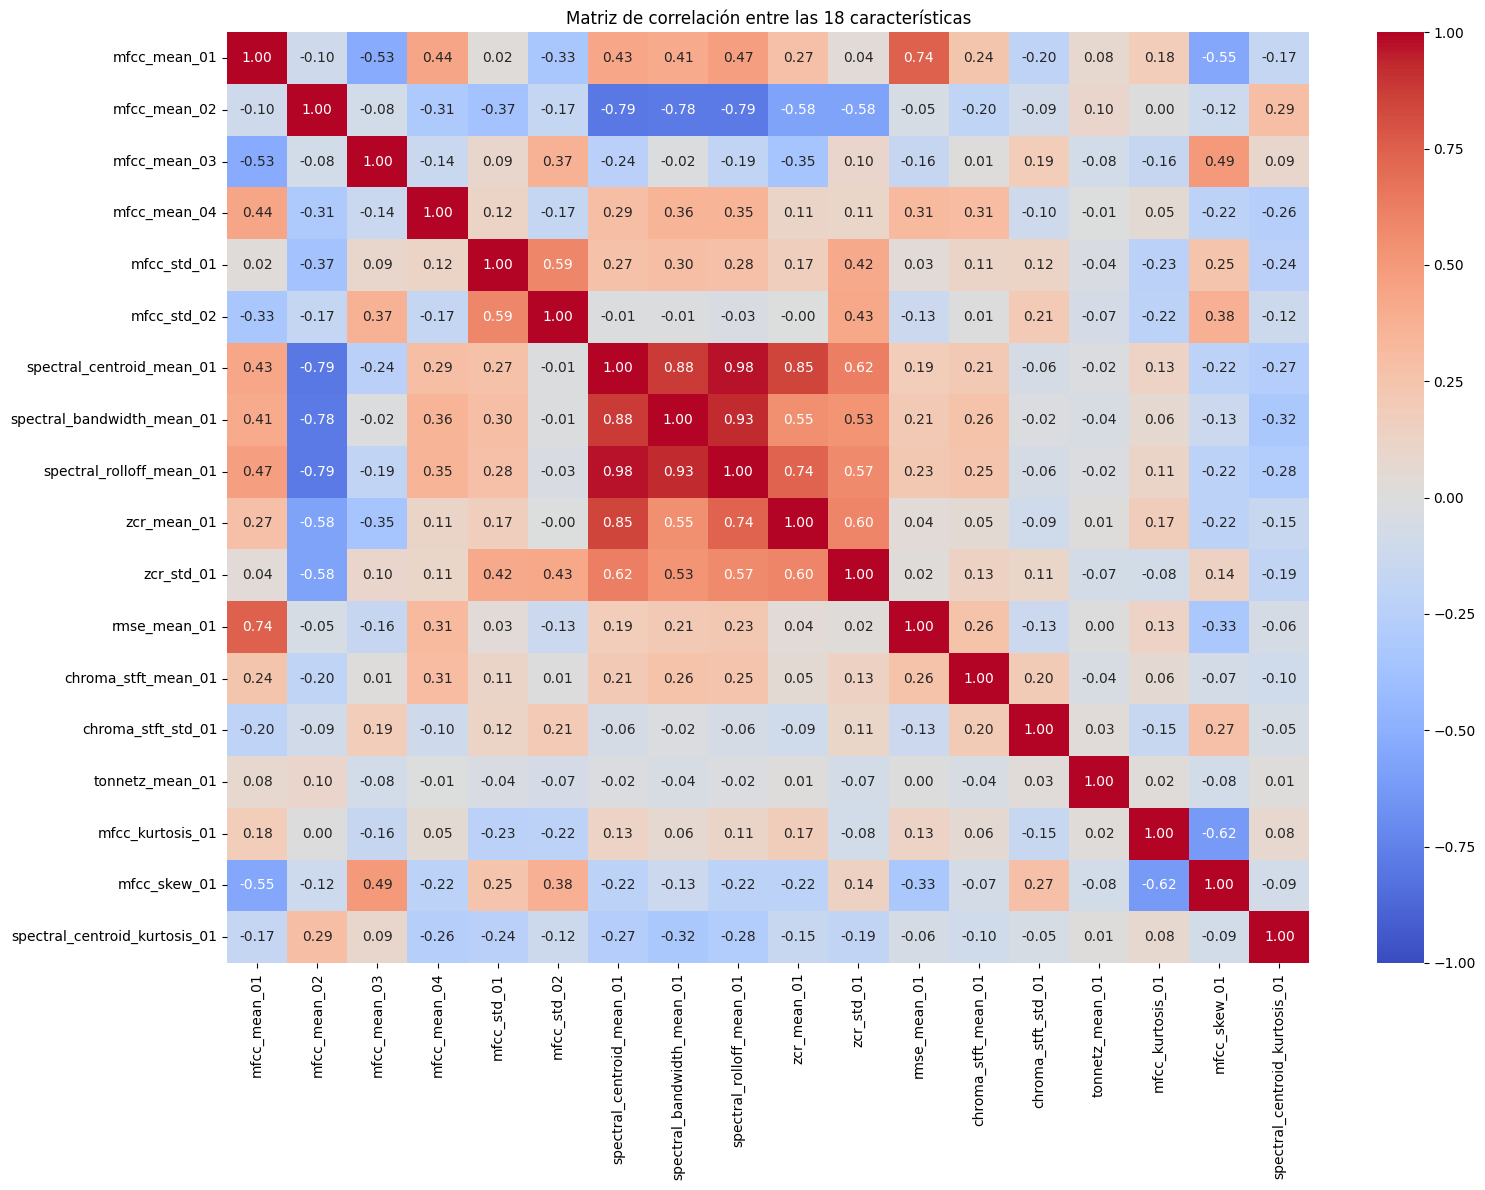

In [37]:
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title('Matriz de correlación entre las 18 características')
plt.tight_layout()
plt.show()

In [38]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_minmaxed)

print("Explained variance por componente:", pca.explained_variance_ratio_)

Explained variance por componente: [0.30063316 0.18130739]


Análisis de Outliers

Identificando Outliers (Valores Atípicos) usando el método IQR:
- chroma_cens_mean_01: 1430 outliers (2.91%)
- chroma_cens_kurtosis_01: 2765 outliers (5.63%)
- mfcc_mean_01: 681 outliers (1.39%)
- mfcc_kurtosis_01: 4009 outliers (8.16%)
- spectral_centroid_mean_01: 1230 outliers (2.50%)
- spectral_centroid_kurtosis_01: 5607 outliers (11.41%)
- rmse_mean_01: 882 outliers (1.80%)
- rmse_kurtosis_01: 3888 outliers (7.91%)
- zcr_mean_01: 1824 outliers (3.71%)
- zcr_kurtosis_01: 5314 outliers (10.82%)


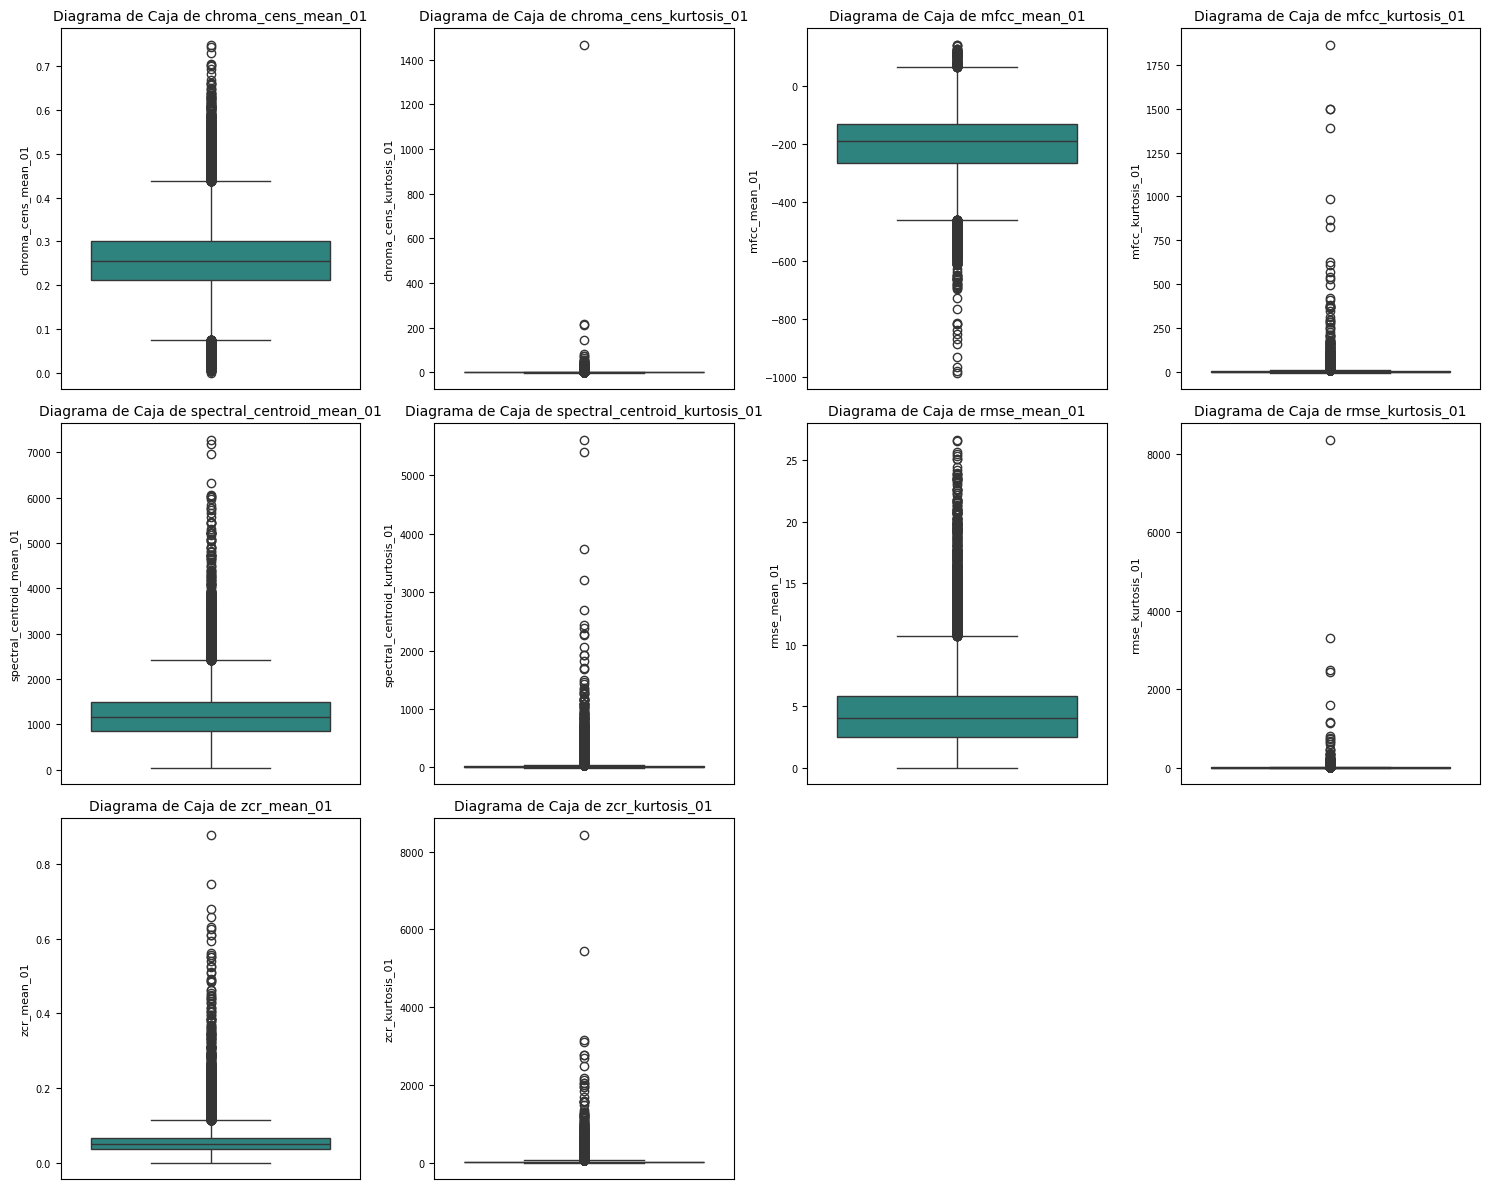

In [39]:
# Seleccionamos las mismas columnas numéricas representativas para visualizar outliers
selected_numerical_cols_for_outlier_plot = [
    'chroma_cens_mean_01', 'chroma_cens_kurtosis_01',
    'mfcc_mean_01', 'mfcc_kurtosis_01',
    'spectral_centroid_mean_01', 'spectral_centroid_kurtosis_01',
    'rmse_mean_01', 'rmse_kurtosis_01',
    'zcr_mean_01', 'zcr_kurtosis_01'
]

# Filtrar solo las columnas que existen en el DataFrame
cols_to_plot_outliers = [col for col in selected_numerical_cols_for_outlier_plot if col in df_merged.columns]

# Identificando Outliers (Valores Atípicos) usando el método IQR y mostrando información
print("Identificando Outliers (Valores Atípicos) usando el método IQR:")

outlier_info = {}
# Iteramos sobre cada columna numérica para calcular valores atípicos
# Calculamos solo las columnas seleccionadas para evitar iterar innecesariamente por las 518 columnas.
for col in cols_to_plot_outliers:
    if col in df_merged.columns:
        Q1 = df_merged[col].quantile(0.25)
        Q3 = df_merged[col].quantile(0.75)
        IQR = Q3 - Q1

        # Definimos los límites para identificar outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificamos outliers
        outliers = df_merged[(df_merged[col] < lower_bound) | (df_merged[col] > upper_bound)]

        # Contamos el número y porcentaje de outliers
        num_outliers = outliers.shape[0]
        percentage_outliers = (num_outliers / df_merged.shape[0]) * 100

        outlier_info[col] = {'num_outliers': num_outliers, 'percentage_outliers': percentage_outliers}
        print(f"- {col}: {num_outliers} outliers ({percentage_outliers:.2f}%)")
    else:
        print(f"- {col}: Información no disponible (columna no encontrada).")


# Generar diagramas de caja para las columnas seleccionadas para visualizar outliers
n_cols = 4
n_rows = (len(cols_to_plot_outliers) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(cols_to_plot_outliers):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(data=df_merged, y=col, palette='viridis')
    plt.title(f'Diagrama de Caja de {col}', fontsize=10)
    plt.ylabel(col, fontsize=8)
    plt.yticks(fontsize=7)
    plt.xticks([])

plt.tight_layout()
plt.show()

Deteccion de valores atipicos.

Factorizamos columna genre_top

Guardamos en un .json los valores de las variables categóricas y eliminamos las columnas que ya no necesitamos

In [40]:
output_dir = os.path.join('./music_genre_identifier/src/factorized_data')
os.makedirs(output_dir, exist_ok=True)

# Asumimos que df_merged ya existe y está listo
cleaned_data = df_merged.copy()

# 1. Factoriza la columna para convertirla a números
codes, uniques = pd.factorize(df_merged['genre_top'])
transformation_rules = {int(code): original_cat for code, original_cat in enumerate(uniques)}
cleaned_data['genre_top'] = codes

# 2. Crea y guarda las reglas de transformación en un archivo JSON
json_file_path = os.path.join(output_dir, "factorized_genre_top.json")

with open(json_file_path, "w") as f:
    json.dump(transformation_rules, f, indent=4)


cleaned_data.drop(['genres', 'genres_all'], axis=1, inplace=True)
print(f"Reglas de factorización guardadas en: {json_file_path}")

# --- (Opcional) Guarda el DataFrame modificado en un archivo CSV ---
df_path = os.path.join(output_dir, "dataframe_factorizado.csv")
cleaned_data.to_csv(df_path, index=False)
print(f"DataFrame modificado guardado en: {df_path}")

df_merged = cleaned_data
display(df_merged.head())

Reglas de factorización guardadas en: ./music_genre_identifier/src/factorized_data/factorized_genre_top.json
DataFrame modificado guardado en: ./music_genre_identifier/src/factorized_data/dataframe_factorizado.csv


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        7.179688                 5.230469   
3                        1.888672                 0.760742   
5                        0.527344                -0.077637   
10                       3.703125                -0.291260   
134                      0.918457                 0.674316   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249268                 1.347656   
3                        0.345215                 2.294922   
5                       -0.279541                 0.686035   
10                       2.197266                -0.234497   
134                      0.577637                 1.281250   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482422                 0.531250   
3                        1.654297                 0.067566   
5                        1.937500                 0.880859   
10                       1.367188                 0.998535   
134                      0.933594                 0.078186   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481445                 2.691406   
3                        1.367188                 1.053711   
5                       -0.923340                -0.927246   
10                       1.770508                 1.604492   
134                      1.199219                -0.175171   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866699                 1.340820   
3                        0.108093                 0.619141   
5                        0.666504                 1.038086   
10                       0.520996                 1.982422   
134                      0.925293                 1.438477   

          chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  \
track_id                                                     
2                        1.347656                 1.237305   
3                        1.038086                 1.291992   
5                        0.269043                 1.125000   
10                       4.328125                 1.300781   
134                      0.123352                 0.797363   

          chroma_cens_max_01  chroma_cens_max_02  chroma_cens_max_03  \
track_id                                                               
2                   0.692383            0.569336            0.597168   
3                   0.677734            0.584473            0.581055   
5                   0.610840            0.651367            0.494629   
10                  0.461914            0.540527            0.446777   
134                 0.670898            0.597168            0.614746   

          chroma_cens_max_04  chroma_cens_max_05  chroma_cens_max_06  \
track_id                                                               
2                   0.625977            0.567383            0.443848   
3                   0.581055            0.454346            0.464844   
5                   0.448730            0.468506            0.454102   
10                  0.647461            0.591797            0.513184   
134                 0.535645            0.617676            0.623535   

          chroma_cens_max_07  chroma_cens_max_08  chroma_cens_max_09  \
track_id                                                               
2                   0.488037            0.497314            0.574219   
3                   0.542969            0.664551            0.511230   
5                   0.497070            0.559570            0.671387   
10                  0.651367  

In [41]:
print(df_merged.columns)

Index(['chroma_cens_kurtosis_01', 'chroma_cens_kurtosis_02',
       'chroma_cens_kurtosis_03', 'chroma_cens_kurtosis_04',
       'chroma_cens_kurtosis_05', 'chroma_cens_kurtosis_06',
       'chroma_cens_kurtosis_07', 'chroma_cens_kurtosis_08',
       'chroma_cens_kurtosis_09', 'chroma_cens_kurtosis_10',
       ...
       'tonnetz_std_05', 'tonnetz_std_06', 'zcr_kurtosis_01', 'zcr_max_01',
       'zcr_mean_01', 'zcr_median_01', 'zcr_min_01', 'zcr_skew_01',
       'zcr_std_01', 'genre_top'],
      dtype='object', length=519)


In [42]:
df_CON_outliers = df_merged.copy()

df_SIN_outliers = df_merged.copy()


def replace_outliers_from_column(column, df):
  """
  Calculamos los límites de outliers usando IQR y acota los valores fuera de esos límites.
  Retorna el DataFrame modificado y los límites calculados.
  """
  # Aseguremos de que la columna sea numérica
  if pd.api.types.is_numeric_dtype(df[column]):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definimos los límites para identificar y acotar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)

    return df, [lower_bound, upper_bound]
  else:
    print(f"La columna '{column}' no es numérica. Saltando el acotamiento de outliers.")
    return df, None


numerical_cols = df_SIN_outliers.select_dtypes(include=np.number).columns.tolist()


outliers_limits_dict = {}

print("Aplicando acotamiento de outliers a columnas numéricas...")
for column in numerical_cols:
  df_SIN_outliers, limit_list = replace_outliers_from_column(column, df_SIN_outliers)
  if limit_list:
    outliers_limits_dict[column] = limit_list

print("Acotamiento de outliers completado.")


print("\nVerificando outliers después del acotamiento (usando el mismo método IQR con 1.5*IQR):")
outliers_after_capping_info = {}
for col in numerical_cols:
    if pd.api.types.is_numeric_dtype(df_SIN_outliers[col]):
        Q1 = df_SIN_outliers[col].quantile(0.25)
        Q3 = df_SIN_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_SIN_outliers[(df_SIN_outliers[col] < lower_bound) | (df_SIN_outliers[col] > upper_bound)]
        num_outliers_after = outliers.shape[0]
        if num_outliers_after > 0:
             outliers_after_capping_info[col] = num_outliers_after

if outliers_after_capping_info:
    print("Columnas que aún pueden mostrar outliers (usando 1.5*IQR después del capping):")
    for col, count in outliers_after_capping_info.items():
        print(f"- {col}: {count} outliers")
    print("\nNota: Es normal que algunas columnas aún muestren outliers con este método después del capping, ya que el capping ajusta los valores a los límites, pero la distribución puede seguir teniendo 'colas' que superen 1.5*IQR de los nuevos cuartiles.")
else:
    print("No se detectaron outliers (usando 1.5*IQR) después del acotamiento en las columnas numéricas.")

print("\nConvirtiendo todas las columnas de ambos DataFrames a float16...")
df_SIN_outliers = df_SIN_outliers.astype('float16')
df_CON_outliers = df_CON_outliers.astype('float16')
print("Conversión a float16 completada para ambos DataFrames.")

# --- Código CORRECTO para convertir 'genre_top' ---
print("\nOptimizando la columna 'genre_top' de int64 a int16...")
df_CON_outliers['genre_top'] = df_CON_outliers['genre_top'].astype('int16')
df_SIN_outliers['genre_top'] = df_SIN_outliers['genre_top'].astype('int16')
print("Columna 'genre_top' optimizada a tipo int16.")

# Mostrar las primeras filas del DataFrame con outliers acotados
print("\nPrimeras filas del DataFrame con outliers acotados:")
display(df_SIN_outliers.head())


Aplicando acotamiento de outliers a columnas numéricas...
Acotamiento de outliers completado.

Verificando outliers después del acotamiento (usando el mismo método IQR con 1.5*IQR):
No se detectaron outliers (usando 1.5*IQR) después del acotamiento en las columnas numéricas.

Convirtiendo todas las columnas de ambos DataFrames a float16...
Conversión a float16 completada para ambos DataFrames.

Optimizando la columna 'genre_top' de int64 a int16...
Columna 'genre_top' optimizada a tipo int16.

Primeras filas del DataFrame con outliers acotados:


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        2.255859                 2.117188   
3                        1.888672                 0.760742   
5                        0.527344                -0.077637   
10                       2.255859                -0.291260   
134                      0.918457                 0.674316   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249268                 1.347656   
3                        0.345215                 2.158203   
5                       -0.279541                 0.686035   
10                       2.197266                -0.234497   
134                      0.577637                 1.281250   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482422                 0.531250   
3                        1.654297                 0.067566   
5                        1.937500                 0.880859   
10                       1.367188                 0.998535   
134                      0.933594                 0.078186   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481445                 2.359375   
3                        1.367188                 1.053711   
5                       -0.923340                -0.927246   
10                       1.770508                 1.604492   
134                      1.199219                -0.175171   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866699                 1.340820   
3                        0.108093                 0.619141   
5                        0.666504                 1.038086   
10                       0.520996                 1.982422   
134                      0.925293                 1.438477   

          chroma_cens_kurtosis_11  chroma_cens_kurtosis_12  \
track_id                                                     
2                        1.347656                 1.237305   
3                        1.038086                 1.291992   
5                        0.269043                 1.125000   
10                       2.361328                 1.300781   
134                      0.123352                 0.797363   

          chroma_cens_max_01  chroma_cens_max_02  chroma_cens_max_03  \
track_id                                                               
2                   0.692383            0.569336            0.597168   
3                   0.677734            0.584473            0.581055   
5                   0.610840            0.651367            0.494629   
10                  0.461914            0.540527            0.446777   
134                 0.670898            0.597168            0.614746   

          chroma_cens_max_04  chroma_cens_max_05  chroma_cens_max_06  \
track_id                                                               
2                   0.625977            0.567383            0.443848   
3                   0.581055            0.454346            0.464844   
5                   0.448730            0.468506            0.454102   
10                  0.647461            0.591797            0.513184   
134                 0.535645            0.617676            0.623535   

          chroma_cens_max_07  chroma_cens_max_08  chroma_cens_max_09  \
track_id                                                               
2                   0.488037            0.497314            0.574219   
3                   0.542969            0.664551            0.511230   
5                   0.497070            0.559570            0.671387   
10                  0.651367  

In [43]:
display(df_CON_outliers)

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        7.179688                 5.230469   
3                        1.888672                 0.760742   
5                        0.527344                -0.077637   
10                       3.703125                -0.291260   
134                      0.918457                 0.674316   
...                           ...                      ...   
155315                  -0.319824                 0.652832   
155316                  -0.490234                 0.463867   
155317                  -0.461670                -0.229614   
155318                   0.552246                -0.110474   
155319                  -0.176880                 0.187256   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249268                 1.347656   
3                        0.345215                 2.294922   
5                       -0.279541                 0.686035   
10                       2.197266                -0.234497   
134                      0.577637                 1.281250   
...                           ...                      ...   
155315                   1.300781                -0.605957   
155316                   2.322266                -0.084351   
155317                  -0.496582                -0.422119   
155318                  -0.532227                 0.263184   
155319                  -0.050659                 0.368896   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482422                 0.531250   
3                        1.654297                 0.067566   
5                        1.937500                 0.880859   
10                       1.367188                 0.998535   
134                      0.933594                 0.078186   
...                           ...                      ...   
155315                  -1.109375                -1.006836   
155316                   1.663086                 2.115234   
155317                   0.130615                -0.263916   
155318                  -0.223999                -0.530762   
155319                   0.065979                -0.857422   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481445                 2.691406   
3                        1.367188                 1.053711   
5                       -0.923340                -0.927246   
10                       1.770508                 1.604492   
134                      1.199219                -0.175171   
...                           ...                      ...   
155315                   0.059631                 0.472656   
155316                  -0.237793                 5.695312   
155317                  -0.627930                -0.082703   
155318                   1.713867                 1.417969   
155319                  -0.780762                 0.626465   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866699                 1.340820   
3                        0.108093                 0.619141   
5                        0.666504                 1.038086   
10                       0.520996                 1.982422   
134                      0.925293                 1.438477   
...                           ...                      ...   
155315                  -0.856445                -0.524902   
155316                   0.830566                 1.952148   
155317                  -0.229492                -0.492676   
155318                   1.325195                 0.120361   
155319                  -0.630859     

In [44]:
display(df_SIN_outliers)

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
track_id                                                     
2                        2.255859                 2.117188   
3                        1.888672                 0.760742   
5                        0.527344                -0.077637   
10                       2.255859                -0.291260   
134                      0.918457                 0.674316   
...                           ...                      ...   
155315                  -0.319824                 0.652832   
155316                  -0.490234                 0.463867   
155317                  -0.461670                -0.229614   
155318                   0.552246                -0.110474   
155319                  -0.176880                 0.187256   

          chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  \
track_id                                                     
2                        0.249268                 1.347656   
3                        0.345215                 2.158203   
5                       -0.279541                 0.686035   
10                       2.197266                -0.234497   
134                      0.577637                 1.281250   
...                           ...                      ...   
155315                   1.300781                -0.605957   
155316                   2.314453                -0.084351   
155317                  -0.496582                -0.422119   
155318                  -0.532227                 0.263184   
155319                  -0.050659                 0.368896   

          chroma_cens_kurtosis_05  chroma_cens_kurtosis_06  \
track_id                                                     
2                        1.482422                 0.531250   
3                        1.654297                 0.067566   
5                        1.937500                 0.880859   
10                       1.367188                 0.998535   
134                      0.933594                 0.078186   
...                           ...                      ...   
155315                  -1.109375                -1.006836   
155316                   1.663086                 2.115234   
155317                   0.130615                -0.263916   
155318                  -0.223999                -0.530762   
155319                   0.065979                -0.857422   

          chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
track_id                                                     
2                        1.481445                 2.359375   
3                        1.367188                 1.053711   
5                       -0.923340                -0.927246   
10                       1.770508                 1.604492   
134                      1.199219                -0.175171   
...                           ...                      ...   
155315                   0.059631                 0.472656   
155316                  -0.237793                 2.359375   
155317                  -0.627930                -0.082703   
155318                   1.713867                 1.417969   
155319                  -0.780762                 0.626465   

          chroma_cens_kurtosis_09  chroma_cens_kurtosis_10  \
track_id                                                     
2                        0.866699                 1.340820   
3                        0.108093                 0.619141   
5                        0.666504                 1.038086   
10                       0.520996                 1.982422   
134                      0.925293                 1.438477   
...                           ...                      ...   
155315                  -0.856445                -0.524902   
155316                   0.830566                 1.952148   
155317                  -0.229492                -0.492676   
155318                   1.325195                 0.120361   
155319                  -0.630859     

In [45]:
df_CON_outliers.isnull().sum().sort_values(ascending=False)

genre_top                  0
chroma_cens_kurtosis_01    0
chroma_cens_kurtosis_02    0
chroma_cens_kurtosis_03    0
chroma_cens_kurtosis_04    0
                          ..
chroma_cens_kurtosis_12    0
chroma_cens_kurtosis_11    0
chroma_cens_kurtosis_10    0
chroma_cens_kurtosis_09    0
chroma_cens_kurtosis_08    0
Length: 519, dtype: int64

In [46]:
df_SIN_outliers.isnull().sum().sort_values(ascending=False)

genre_top                  0
chroma_cens_kurtosis_01    0
chroma_cens_kurtosis_02    0
chroma_cens_kurtosis_03    0
chroma_cens_kurtosis_04    0
                          ..
chroma_cens_kurtosis_12    0
chroma_cens_kurtosis_11    0
chroma_cens_kurtosis_10    0
chroma_cens_kurtosis_09    0
chroma_cens_kurtosis_08    0
Length: 519, dtype: int64

### Split Train test

In [47]:
base_url = '../content/music_genre_identifier/'

In [48]:
target = ["genre_top"]

def split(target, df_merged, reference: str, test_size=0.2, random_state=123):
    X = df_merged.drop(columns=target)
    y = df_merged[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    X_train.to_parquet(f'{base_url}data/processed/X_train_{reference}.parquet', index=False)
    X_test.to_parquet(f'{base_url}data/processed/X_test_{reference}.parquet', index=False)
    y_train.to_frame().to_parquet(f'{base_url}data/processed/y_train.parquet', index=False)
    y_test.to_frame().to_parquet(f'{base_url}data/processed/y_test.parquet', index=False)

    return X_train, X_test, y_train, y_test

X_train_con_outliers, X_test_con_outliers, y_train, y_test = split('genre_top', df_CON_outliers, 'con_outliers')
X_train_sin_outliers, X_test_sin_outliers, _, _ = split('genre_top', df_SIN_outliers, 'sin_outliers')

try:
    X_train_con_outliers = pd.read_parquet(f'.{base_url}data/processed/X_train_con_outliers.parquet')
    X_train_sin_outliers = pd.read_parquet(f'.{base_url}data/processed/X_train_sin_outliers.parquet')

    X_test_con_outliers = pd.read_parquet(f'{base_url}data/processed/X_test_con_outliers.parquet')
    X_test_sin_outliers = pd.read_parquet(f'{base_url}data/processed/X_test_sin_outliers.parquet')


    # Cargar y_train y y_test (estos son comunes para todos los X)
    y_train = pd.read_parquet(f'{base_url}data/processed/y_train.parquet').squeeze()
    y_test = pd.read_parquet(f'{base_url}data/processed/y_test.parquet').squeeze()

    print("All .parquet variables readed successfully")


except FileNotFoundError:
    print("Error: Not all preprocessed data files were found.")
except Exception as e:
    print("Unexpected error: ", e)

Error: Not all preprocessed data files were found.


### Normalización

In [49]:
def norm(X_train:pd.DataFrame, X_test:pd.DataFrame, reference:str):
    scaler = StandardScaler()
    scaler.fit(X_train)

    scaler_filename = os.path.join(f'{base_url}models', f'scaler_{reference}.pkl')
    with open(scaler_filename, "wb") as file:
        pickle.dump(scaler, file)

    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)
    X_train_norm = X_train_norm.astype('float16')
    X_train_norm.to_parquet(f'{base_url}data/processed/X_train_{reference}_norm.parquet', index=False)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)
    X_test_norm = X_test_norm.astype('float16')
    X_test_norm.to_parquet(f'{base_url}data/processed/X_test_{reference}_norm.parquet', index=False)

    return X_train_norm, X_test_norm

X_train_con_outliers_norm, X_test_con_outliers_norm = norm(X_train_con_outliers, X_test_sin_outliers, 'con_outliers')
X_train_sin_outliers_norm, X_test_sin_outliers_norm = norm(X_train_sin_outliers, X_test_sin_outliers, 'sin_outliers')

X_train_sin_outliers_norm.head()

try:
    X_train_con_outliers_norm = pd.read_parquet(f'{base_url}data/processed/X_train_con_outliers_norm.parquet')
    X_train_sin_outliers_norm = pd.read_parquet(f'{base_url}data/processed/X_train_sin_outliers_norm.parquet')

    X_test_con_outliers_norm = pd.read_parquet(f'{base_url}data/processed/X_test_con_outliers_norm.parquet')
    X_test_sin_outliers_norm = pd.read_parquet(f'{base_url}data/processed/X_test_sin_outliers_norm.parquet')

    print("All .parquet variables readed successfully")

except FileNotFoundError:
    print("Error: Not all preprocessed data files were found.")
except Exception as e:
    print("Unexpected error: ", e)

All .parquet variables readed successfully


### Escalado Min-Max

In [50]:
def minmax(X_train:pd.DataFrame, X_test:pd.DataFrame, reference:str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)

    scaler_filename = os.path.join(f'{base_url}models', f'scaler_{reference}.pkl')
    with open(scaler_filename, "wb") as file:
        pickle.dump(scaler, file)

    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)
    X_train_minmax = X_train_minmax.astype('float16')
    X_train_minmax.to_parquet(f'{base_url}data/processed/X_train_{reference}_minmax.parquet', index=False)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    X_test_minmax = X_test_minmax.astype('float16')
    X_test_minmax.to_parquet(f'{base_url}data/processed/X_test_{reference}_minmax.parquet', index=False)

    return X_train_minmax, X_test_minmax

X_train_con_outliers_minmax, X_test_con_outliers_minmax = minmax(X_train_con_outliers, X_test_con_outliers, 'con_outliers')
X_train_sin_outliers_minmax, X_test_sin_outliers_minmax = minmax(X_train_sin_outliers, X_test_sin_outliers, 'sin_outliers')

X_train_sin_outliers_minmax.head()

try:
    X_train_con_outliers_minmax = pd.read_parquet(f'{base_url}data/processed/X_train_con_outliers_minmax.parquet')
    X_train_sin_outliers_minmax = pd.read_parquet(f'{base_url}data/processed/X_train_sin_outliers_minmax.parquet')

    X_test_con_outliers_minmax = pd.read_parquet(f'{base_url}data/processed/X_test_con_outliers_minmax.parquet')
    X_test_sin_outliers_minmax = pd.read_parquet(f'{base_url}data/processed/X_test_sin_outliers_minmax.parquet')

    print("All .parquet variables readed successfully")

except FileNotFoundError:
    print("Error: Not all preprocessed data files were found.")
except Exception as e:
    print("Unexpected error: ", e)

All .parquet variables readed successfully


## Machine Learning

In [51]:
# Una vez hecho el EDA eliminaremos variables que ya no usemos más para mejorar la memoria
del df, path, tracks_raw, features_raw, features_processed, genres_df, cleaned_data, df_merged,

### Models

#### Neuronal Network

In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import os

# Asumiendo que estas variables ya están cargadas
# X_train_con_outliers, X_test_con_outliers, etc.
# y_train, y_test
# transformation_rules, etc.

# Definir la arquitectura base de la red neuronal
def build_simple_nn(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Usar las mismas variables del código de Random Forest
results = []
dataset_references = {
    "X_train_con_outliers": (X_train_con_outliers, X_test_con_outliers),
    "X_train_sin_outliers": (X_train_sin_outliers, X_test_sin_outliers),
    "X_train_con_outliers_norm": (X_train_con_outliers_norm, X_test_con_outliers_norm),
    "X_train_sin_outliers_norm": (X_train_sin_outliers_norm, X_test_sin_outliers_norm),
    "X_train_con_outliers_minmax": (X_train_con_outliers_minmax, X_test_con_outliers_minmax),
    "X_train_sin_outliers_minmax": (X_train_sin_outliers_minmax, X_test_sin_outliers_minmax),
}

data_fraction = 0.99 # Usar el 10% de los datos
# Correctly determine the number of classes from the unique values in y_train and y_test
all_unique_classes = pd.concat([y_train, y_test]).unique()
num_classes = len(all_unique_classes)

# Codificar las etiquetas en one-hot encoding para la red neuronal
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)


for dataset_name, (X_train, X_test) in dataset_references.items():
    print(f"Evaluando {dataset_name}...")

    # Tomar un subconjunto de los datos para un entrenamiento rápido
    X_train_subset = X_train.sample(frac=data_fraction, random_state=42)
    y_train_subset_encoded = y_train_encoded[X_train_subset.index]

    X_test_subset = X_test.sample(frac=data_fraction, random_state=42)
    y_test_subset_encoded = y_test_encoded[X_test_subset.index]


    # Construir y entrenar el modelo base
    model = build_simple_nn(X_train_subset.shape[1], num_classes)
    model.fit(X_train_subset, y_train_subset_encoded, epochs=10, batch_size=32, verbose=0)

    # Evaluar la precisión en el subconjunto de prueba
    loss, accuracy = model.evaluate(X_test_subset, y_test_subset_encoded, verbose=0)

    results.append({
        "dataset_name": dataset_name,
        "accuracy": accuracy
    })

results_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
print("\n--- Resultados de la Evaluación Rápida ---")
print(results_df)

winning_dataset_name = results_df.iloc[0]["dataset_name"]
print(f'\nEl mejor conjunto de datos es {winning_dataset_name} con una precisión del {results_df.iloc[0]["accuracy"] * 100:.4f}%')
winning_dataset_X_train, winning_dataset_X_test = dataset_references[winning_dataset_name]

Evaluando X_train_con_outliers...
Evaluando X_train_sin_outliers...
Evaluando X_train_con_outliers_norm...
Evaluando X_train_sin_outliers_norm...
Evaluando X_train_con_outliers_minmax...
Evaluando X_train_sin_outliers_minmax...

--- Resultados de la Evaluación Rápida ---
                  dataset_name  accuracy
3    X_train_sin_outliers_norm  0.662247
2    X_train_con_outliers_norm  0.653716
5  X_train_sin_outliers_minmax  0.627300
4  X_train_con_outliers_minmax  0.576935
1         X_train_sin_outliers  0.281221
0         X_train_con_outliers  0.281221

El mejor conjunto de datos es X_train_sin_outliers_norm con una precisión del 66.2247%


Final Mode, Hyperparameters, and best model saving

In [53]:
# Definimos la función para la búsqueda de hiperparámetros
def build_tunable_nn(hp):
    model = models.Sequential()

    # Optimizamos el número de unidades en la primera capa
    model.add(layers.Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(winning_dataset_X_train.shape[1],)
    ))

    # Optimizamos la tasa de dropout
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Hacemos que la segunda capa sea opcional
    if hp.Boolean("add_second_layer"):
        model.add(layers.Dense(
            units=hp.Int('units_2', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Optimizamos el optimizador
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Creamos el afinador, equivalente a RandomizedSearchCV
tuner = kt.RandomSearch(
    hypermodel=build_tunable_nn,
    objective='val_accuracy',
    max_trials=7,  # Número de combinaciones a probar
    executions_per_trial=1, # Número de entrenamientos por cada prueba
    directory='my_dir',
    project_name='music_genre_tuning'
)

print(f"\nRealizando la búsqueda de hiperparámetros en el mejor conjunto de datos: {winning_dataset_name}")
# Iniciamos la búsqueda en el conjunto de datos completo del ganador
# Usamos los datos de prueba del conjunto ganador como datos de validación
tuner.search(winning_dataset_X_train, y_train_encoded, epochs=50, validation_data=(winning_dataset_X_test, y_test_encoded), verbose=2)

print("\nLos mejores hiperparámetros encontrados son:")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

# Obtener el mejor modelo entrenado
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluar la precisión final con el modelo optimizado
test_loss, test_acc = best_model.evaluate(winning_dataset_X_test, y_test_encoded, verbose=0)
print(f"\nLa precisión del modelo optimizado en el conjunto de prueba es: {test_acc:.4f}")

# Guardar el modelo ganador para su uso futuro
best_model.save(f'./music_genre_identifier/models/neuronal_network.h5')

Trial 7 Complete [00h 04m 46s]
val_accuracy: 0.6782334446907043

Best val_accuracy So Far: 0.6865777969360352
Total elapsed time: 00h 30m 04s

Los mejores hiperparámetros encontrados son:
{'units_1': 256, 'dropout_1': 0.5, 'add_second_layer': True, 'optimizer': 'adam', 'units_2': 96}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       132,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,088 (621.44 KB)

 Trainable params: 159,088 (621.44 KB)

 Non-trainable params: 0 (0.00 B)


La precisión del modelo optimizado en el conjunto de prueba es: 0.6866


#### Random Forest

##### Choosing the Best Dataset

In [54]:
results = []

dataset_references = {
    "X_train_con_outliers": (X_train_con_outliers, X_test_con_outliers),
    "X_train_sin_outliers": (X_train_sin_outliers, X_test_sin_outliers),
    "X_train_con_outliers_norm": (X_train_con_outliers_norm, X_test_con_outliers_norm),
    "X_train_sin_outliers_norm": (X_train_sin_outliers_norm, X_test_sin_outliers_norm),
    "X_train_con_outliers_minmax": (X_train_con_outliers_minmax, X_test_con_outliers_minmax),
    "X_train_sin_outliers_minmax": (X_train_sin_outliers_minmax, X_test_sin_outliers_minmax),
}

data_fraction = 0.1 # Usar el 10% de los datos

for dataset_name, (X_train, X_test) in dataset_references.items():
    X_train_subset = X_train.sample(frac=data_fraction, random_state=42)
    y_train_subset = y_train.loc[X_train_subset.index]

    X_test_subset = X_test.sample(frac=data_fraction, random_state=42)
    y_test_subset = y_test.loc[X_test_subset.index]
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_subset, y_train_subset)
    y_pred = model.predict(X_test_subset)
    accuracy = accuracy_score(y_test_subset, y_pred)

    results.append({
        "dataset_name": dataset_name,
        "accuracy": accuracy
    })

results_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
print(results_df)
winning_dataset_name = results_df.iloc[0]["dataset_name"]
print(f'El mejor conjunto de datos es {winning_dataset_name} con una precisión del {results_df.iloc[0]["accuracy"] * 100:.4f}%')

                  dataset_name  accuracy
1         X_train_sin_outliers  0.553408
5  X_train_sin_outliers_minmax  0.553408
3    X_train_sin_outliers_norm  0.550356
4  X_train_con_outliers_minmax  0.549339
0         X_train_con_outliers  0.545270
2    X_train_con_outliers_norm  0.542218
El mejor conjunto de datos es X_train_sin_outliers con una precisión del 55.3408%


##### Hyperparameter Optimization and Final Accuracy

In [55]:
winning_dataset_X_train, winning_dataset_X_test = dataset_references[winning_dataset_name]

# El 'param_grid' es correcto
param_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(10, 110, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# El 'RandomizedSearchCV' está bien configurado
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print(f"\nRealizando la búsqueda de hiperparámetros en el mejor conjunto de datos: {winning_dataset_name}")
# Se entrena con el conjunto de datos COMPLETO del ganador
rf_random.fit(winning_dataset_X_train, y_train)

print("\nLos mejores hiperparámetros encontrados son:")
print(rf_random.best_params_)

# Obtenemos el mejor modelo entrenado directamente del objeto de búsqueda
best_random_forest_model = rf_random.best_estimator_

# Calculamos la precisión FINAL usando el modelo optimizado en el conjunto de prueba
# COMPLETO del mejor dataset.
best_random_forest_model_accuracy = best_model.score(winning_dataset_X_test, y_test)
print(f"\nLa precisión del modelo optimizado en el conjunto de prueba es: {best_model_accuracy:.4f}")

# La variable 'results_df_tuned' es correcta
results_df_tuned = pd.DataFrame(rf_random.cv_results_)
# Si quieres ver los resultados completos, puedes imprimir:
# print(results_df_tuned)


Realizando la búsqueda de hiperparámetros en el mejor conjunto de datos: X_train_sin_outliers
Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

#### Máquinas de Vectores de Soporte (SVM)

Implementaremos un modelo SVM para clasificación. Debido al tamaño del dataset y a las limitaciones de memoria, utilizaremos una fracción del 10% de los datos para el entrenamiento y la evaluación.

In [ ]:
# Usaremos el mismo porcentaje de datos que en el caso de Random Forest

# Seleccionar el conjunto de datos ganador (asumiendo que ya se determinó en pasos anteriores)
# Asegúrate de que 'winning_dataset_X_train', 'winning_dataset_X_test', 'y_train', 'y_test' están disponibles
# winning_dataset_X_train and winning_dataset_X_test are now defined in the previous cell

X_train_subset_svm = winning_dataset_X_train.sample(frac=data_fraction, random_state=42)
y_train_subset_svm = y_train.loc[X_train_subset_svm.index]
X_test_subset_svm = winning_dataset_X_test.sample(frac=data_fraction, random_state=42)
y_test_subset_svm = y_test.loc[X_test_subset_svm.index]

print(f"Entrenando modelo SVM con el {data_fraction*100}% de los datos del mejor conjunto: {winning_dataset_name}...")

# Inicializar y entrenar el modelo SVM
# Usamos un kernel lineal por defecto para empezar, ya que es menos costoso computacionalmente
# Considera ajustar 'gamma', 'C' y 'kernel' para optimización si el tiempo lo permite

svm_model = SVC(random_state=42, kernel='linear')

# Debido al tamaño del subconjunto, el entrenamiento puede tomar un tiempo.

print("Iniciando entrenamiento del modelo SVM...")

svm_model.fit(X_train_subset_svm, y_train_subset_svm)

print("Entrenamiento del modelo SVM completado.")

# Realizar predicciones en el subconjunto de prueba

print("Realizando predicciones...")

y_pred_svm = svm_model.predict(X_test_subset_svm) # Corrected prediction data

print("Predicciones completadas.")

# Evaluar el modelo

accuracy_svm = accuracy_score(y_test_subset_svm, y_pred_svm)
print(f"\nPrecisión del modelo SVM en el subconjunto de prueba ({data_fraction*100}% de los datos): {accuracy_svm:.4f}")

# Puedes añadir más métricas de evaluación si lo deseas
print("\nReporte de Clasificación:")
print(classification_report(y_test_subset_svm, y_pred_svm))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_subset_svm, y_pred_svm))

#### Optimización de Hiperparámetros para SVM (RandomizedSearchCV)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
# He limitado el número de iteraciones y los rangos de parámetros para un tiempo de ejecución razonable
# Puedes ajustar estos valores si tienes más tiempo y recursos.

param_grid_svm = {
    'C': [0.1, 1, 10, 100], # Parámetro de regularización
    'gamma': ['scale', 'auto', 0.1, 1], # Coeficiente del kernel
    'kernel': ['linear', 'rbf', 'poly'], # Tipos de kernel a probar
    'degree': [2, 3, 4] # Grado para el kernel polinomial (solo relevante si kernel='poly')
}

# Inicializar RandomizedSearchCV
# n_iter: número de combinaciones de parámetros a probar
# cv: número de folds para la validación cruzada
# n_jobs: usar todos los procesadores disponibles (-1)
# Usaremos un subconjunto de los datos de entrenamiento para acelerar la búsqueda.

data_fraction_tuning = 0.1
X_train_subset_tuning = winning_dataset_X_train.sample(frac=data_fraction_tuning, random_state=42)
y_train_subset_tuning = y_train.loc[X_train_subset_tuning.index]

print(f"Realizando búsqueda aleatoria de hiperparámetros para SVM con el {data_fraction_tuning*100}% de los datos de entrenamiento...")

svm_random = RandomizedSearchCV(
    estimator=SVC(random_state=42),
    param_distributions=param_grid_svm,
    n_iter=20, # Número de combinaciones a probar (ajusta según tiempo)
    cv=3, # Validación cruzada (ajusta según tiempo)
    verbose=2,
    random_state=42,
    n_jobs=-1
)
# Ejecutar la búsqueda en el subconjunto de datos
svm_random.fit(X_train_subset_tuning, y_train_subset_tuning)
print("\nMejores hiperparámetros encontrados para SVM:")
print(svm_random.best_params_)

# Evaluar el mejor modelo encontrado en el conjunto de prueba completo (del winning dataset)
best_svm_model = svm_random.best_estimator_
best_svm_accuracy = best_svm_model.score(winning_dataset_X_test, y_test)
print(f"\nPrecisión del mejor modelo SVM en el conjunto de prueba completo: {best_svm_accuracy:.4f}")

#### Regresión Logística


Implementaremos un modelo de Regresión Logística, utilizando una fracción del 10% de los datos para el entrenamiento y la evaluación.

In [ ]:
# Usaremos el mismo porcentaje de datos que en los casos anteriores

print(f"Entrenando modelo de Regresión Logística con el {data_fraction*100}% de los datos del mejor conjunto: {winning_dataset_name}...")

# Seleccionar un subconjunto de los datos de entrenamiento y prueba
X_train_subset_lr = winning_dataset_X_train.sample(frac=data_fraction, random_state=42)
y_train_subset_lr = y_train.loc[X_train_subset_lr.index]
X_test_subset_lr = winning_dataset_X_test.sample(frac=data_fraction, random_state=42)
y_test_subset_lr = y_test.loc[X_test_subset_lr.index]

# Inicializar y entrenar el modelo de Regresión Logística
# Ajustamos max_iter para asegurar la convergencia
log_reg_model = LogisticRegression(random_state=42, multi_class='auto', solver='liblinear', max_iter=1000)
print("Iniciando entrenamiento del modelo de Regresión Logística...")

log_reg_model.fit(X_train_subset_lr, y_train_subset_lr)
print("Entrenamiento del modelo de Regresión Logística completado.")

# Realizar predicciones en el subconjunto de prueba
print("Realizando predicciones...")
y_pred_lr = log_reg_model.predict(X_test_subset_lr)
print("Predicciones completadas.")

# Evaluar el modelo
accuracy_lr = accuracy_score(y_test_subset_lr, y_pred_lr)
print(f"\nPrecisión del modelo de Regresión Logística en el subconjunto de prueba ({data_fraction*100}% de los datos): {accuracy_lr:.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_test_subset_lr, y_pred_lr))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_subset_lr, y_pred_lr))

In [ ]:
winning_dataset = best_model